In [1]:
# from tensorflow.keras.models import load_model
import numpy as np
import tensorflow as tf
from neurite_sandbox.tf.models import labels_to_labels
from neurite_sandbox.tf.utils.augment import add_outside_shapes
from neurite.tf.utils.augment import draw_perlin_full
from scipy.ndimage import distance_transform_edt
import scipy.ndimage as ndi
import tensorflow.keras.layers as KL
import voxelmorph as vxm


import argparse
from tensorflow.keras.callbacks import ReduceLROnPlateau
import pathlib
# import surfa as sf
import re
import json
from keras import backend as K
import param_3d
import data
import model_3d
from data_3d import *
import scipy.ndimage as ndimage

import nibabel as nib
from tqdm import tqdm
from tensorflow.keras.layers import Lambda

from utils import *
from help import *

import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# Check devices
print("Available devices:", tf.config.list_physical_devices())

def get_pig_model(k1,k2):
    epsilon =1e-7
    min_max_norm = Lambda(lambda x: (x - K.min(x)) / (K.max(x) - K.min(x)+ epsilon) * (1.0) )
    
    print("model is loading")
    en = [16 ,16 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64]
    de = [64 ,64 ,64 ,64, 64 ,64 ,64, 64, 64, 16 ,16 ,2]
    input_img = Input(shape=(param_3d.img_size_192,param_3d.img_size_192,param_3d.img_size_192, 1))
    unet_model = vxm.networks.Unet(inshape=(param_3d.img_size_192,param_3d.img_size_192,param_3d.img_size_192, 1), nb_features=(en, de),
                       nb_conv_per_level=2,
                       final_activation_function='softmax')
        
    latest_weight = max(glob.glob(os.path.join("models_gmm_"+str(k1)+"_"+str(k2), 'weights_epoch_*.h5')), key=os.path.getctime, default=None)
    print(latest_weight)
    generated_img_norm = min_max_norm(input_img)
    segmentation = unet_model(generated_img_norm)
    combined_model = Model(inputs=input_img, outputs=segmentation)
    combined_model.load_weights(latest_weight)
    return combined_model

def get_pig_model_128():
    epsilon =1e-7
    min_max_norm = Lambda(lambda x: (x - K.min(x)) / (K.max(x) - K.min(x)+ epsilon) * (1.0) )
    
    print("model is loading")
    en = [16 ,16 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64]
    de = [64 ,64 ,64 ,64, 64 ,64 ,64, 64, 64, 16 ,16 ,2]
    input_img = Input(shape=(param_3d.img_size_128,param_3d.img_size_128,param_3d.img_size_128, 1))
    unet_model = vxm.networks.Unet(inshape=(param_3d.img_size_128,param_3d.img_size_128,param_3d.img_size_128, 1), nb_features=(en, de),
                       nb_conv_per_level=2,
                       final_activation_function='softmax')
        
    latest_weight = max(glob.glob(os.path.join("models_gmm_6_6_128", 'weights_epoch_*.h5')), key=os.path.getctime, default=None)
    print(latest_weight)
    generated_img_norm = min_max_norm(input_img)
    segmentation = unet_model(generated_img_norm)
    combined_model = Model(inputs=input_img, outputs=segmentation)
    combined_model.load_weights(latest_weight)
    return combined_model

/cbica/home/dadashkj/neurite/neurite/__init__.py:33: FutureWarning: The default backend will soon be changing to 'pytorch'. If you prefer to use TensorFlow, please set the NEURITE_BACKEND environment variable to 'tensorflow'.
  backend = py.utils.get_backend()
/cbica/home/dadashkj/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Issue loading cv2


Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


2025-02-21 10:53:30.588357: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-02-21 10:53:30.588438: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: cubic-login3
2025-02-21 10:53:30.588460: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: cubic-login3
2025-02-21 10:53:30.588563: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 460.73.1
2025-02-21 10:53:30.588626: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 460.73.1
2025-02-21 10:53:30.588643: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 460.73.1


In [7]:
k1=3
k2=6
validation_folder_path = "/cubic/projects/Pig_TBI/JohnWolf/Protocols/T1_mask"
subfolders = [f.name for f in os.scandir(validation_folder_path) if f.is_dir()]
combined_model = get_pig_model(k1,k2)
combined_model_128 = get_pig_model_128()

model is loading
models_gmm_3_6/weights_epoch_40.h5
model is loading
models_gmm_6_6_128/weights_epoch_760.h5


/cubic/projects/Pig_TBI/JohnWolf/Protocols/T1_mask/JAW-081_1month/JAW-081_1month_T1.nii.gz
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!


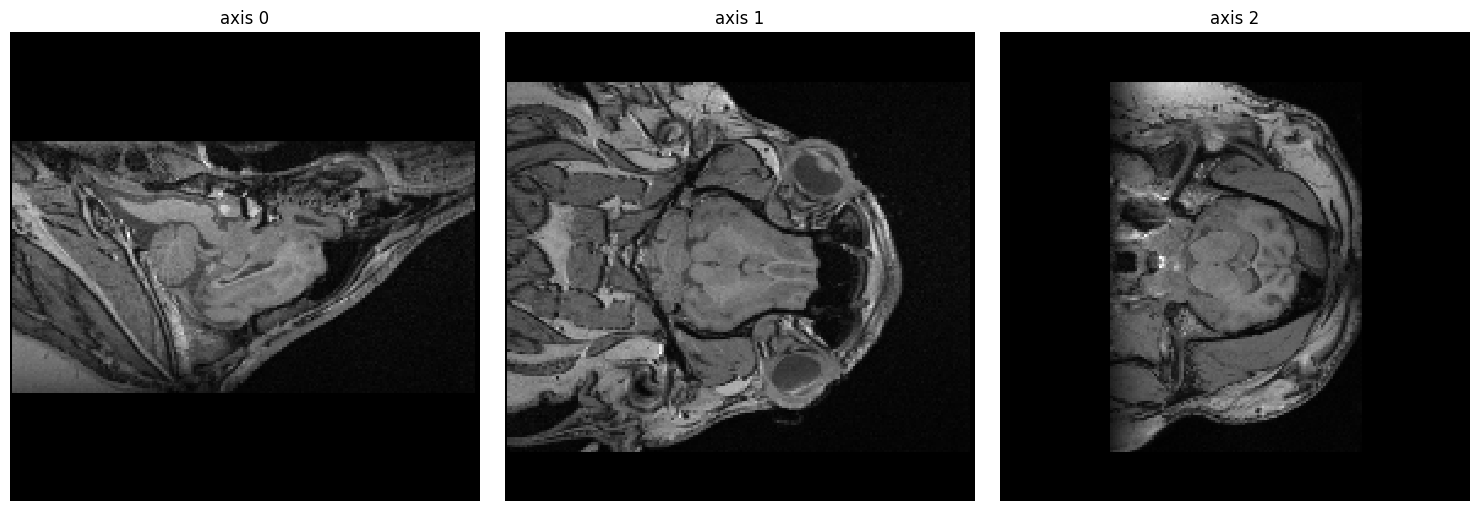

(192, 192, 192)
Initial Prediction Result:
first step:  0.7128946561765608


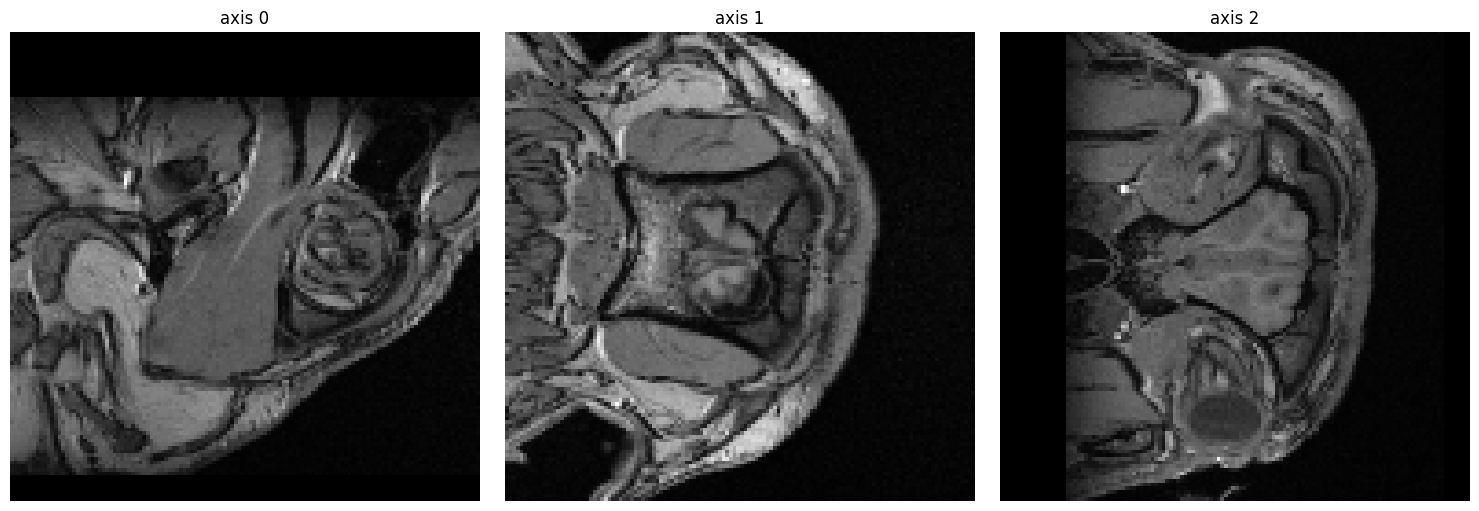

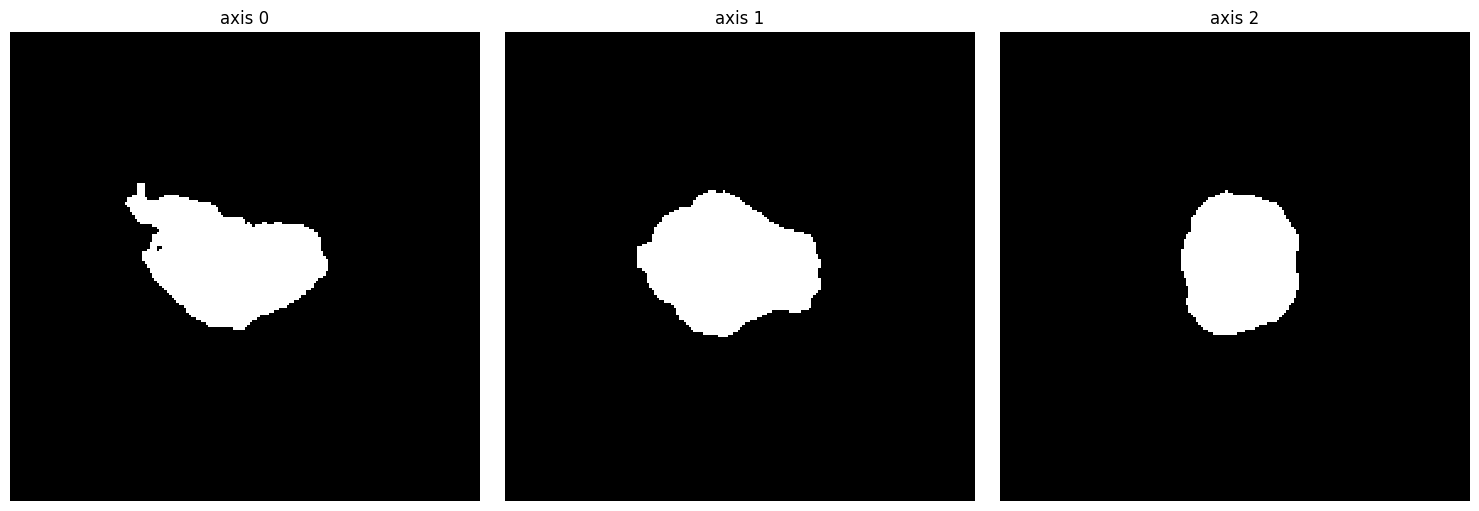

second step:  0.8741236780122846
After Second Prediction:
Dice coefficient for JAW-081_1month: 0.8741
/cubic/projects/Pig_TBI/JohnWolf/Protocols/T1_mask/JAW-076_3day/JAW-076_3day_T1.nii.gz
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!


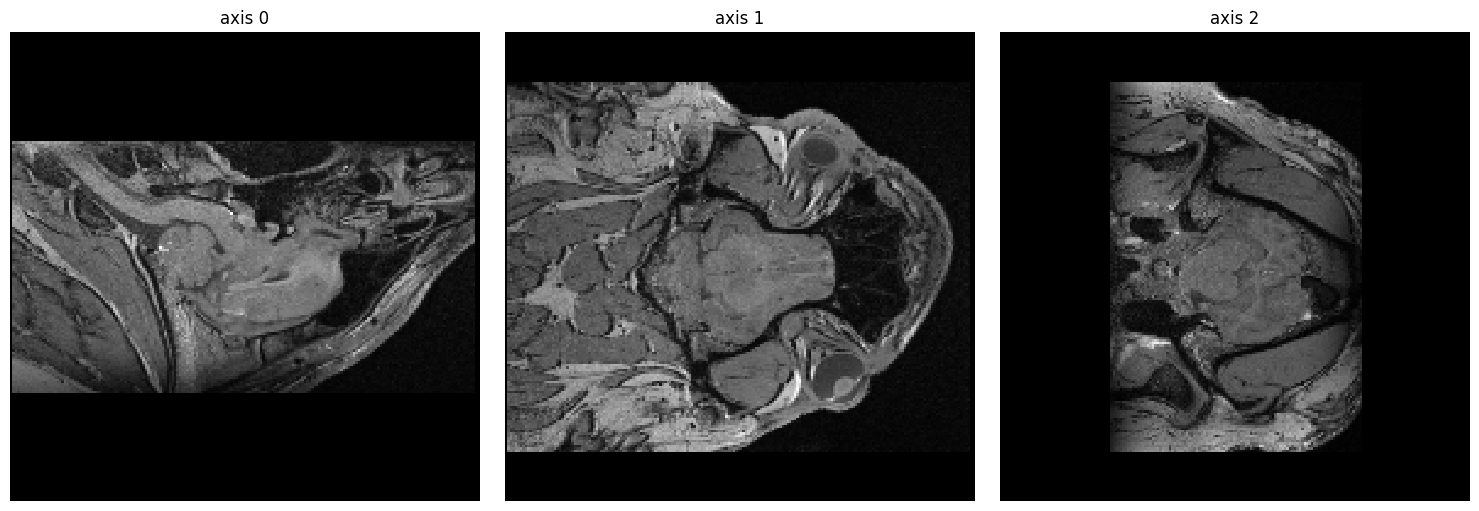

(192, 192, 192)
Initial Prediction Result:
first step:  0.6874058941474672


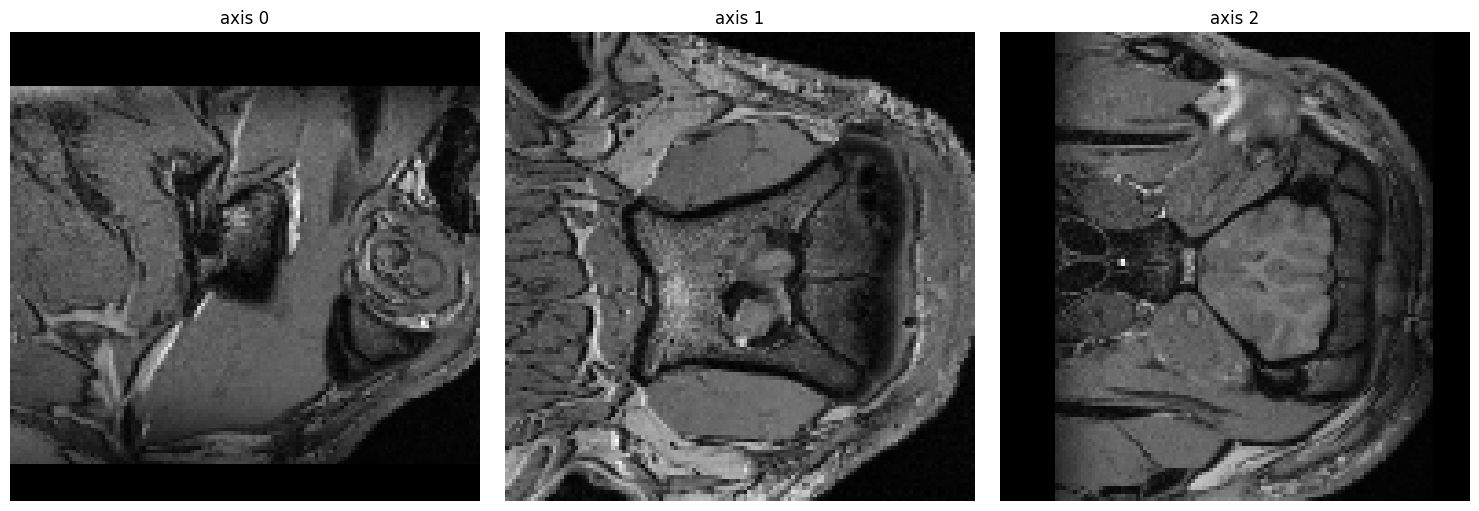

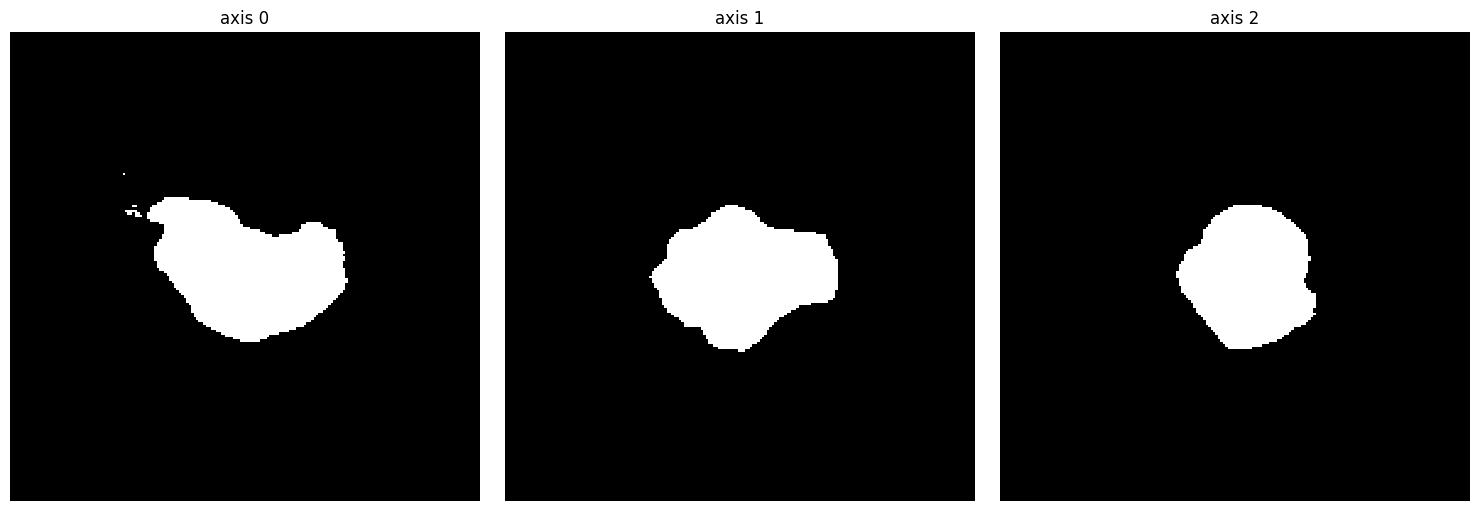

second step:  0.8602803923904841
After Second Prediction:
Dice coefficient for JAW-076_3day: 0.8603
/cubic/projects/Pig_TBI/JohnWolf/Protocols/T1_mask/JAW-082/JAW-082_T1.nii.gz
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!


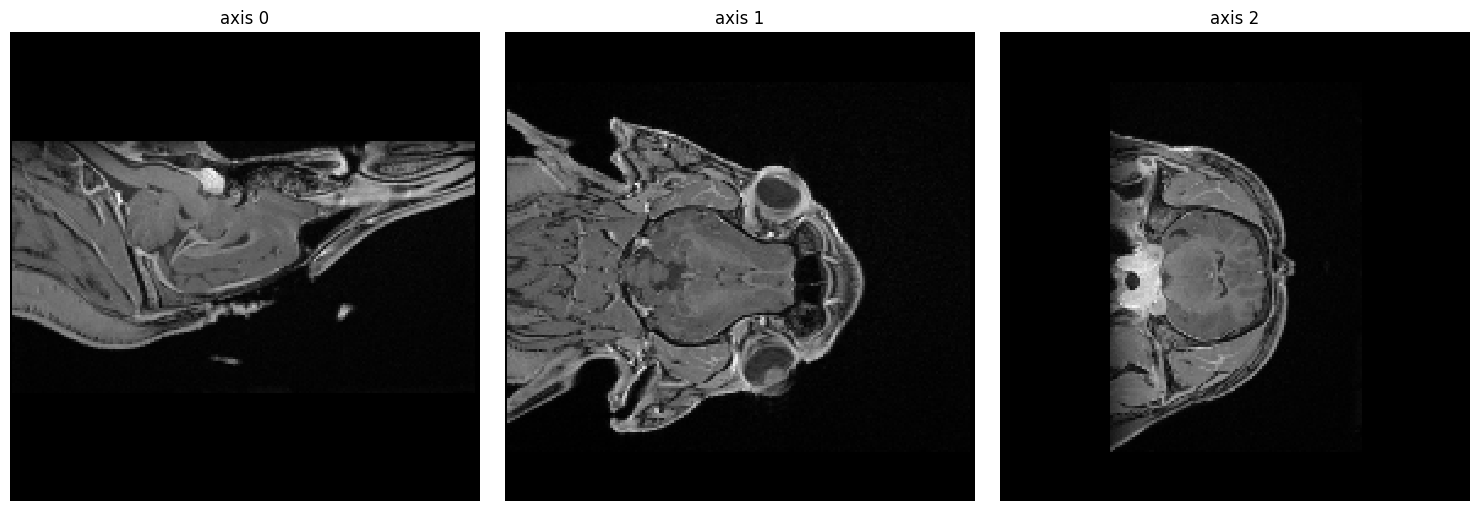

(192, 192, 192)
Initial Prediction Result:
first step:  0.7343129880692485


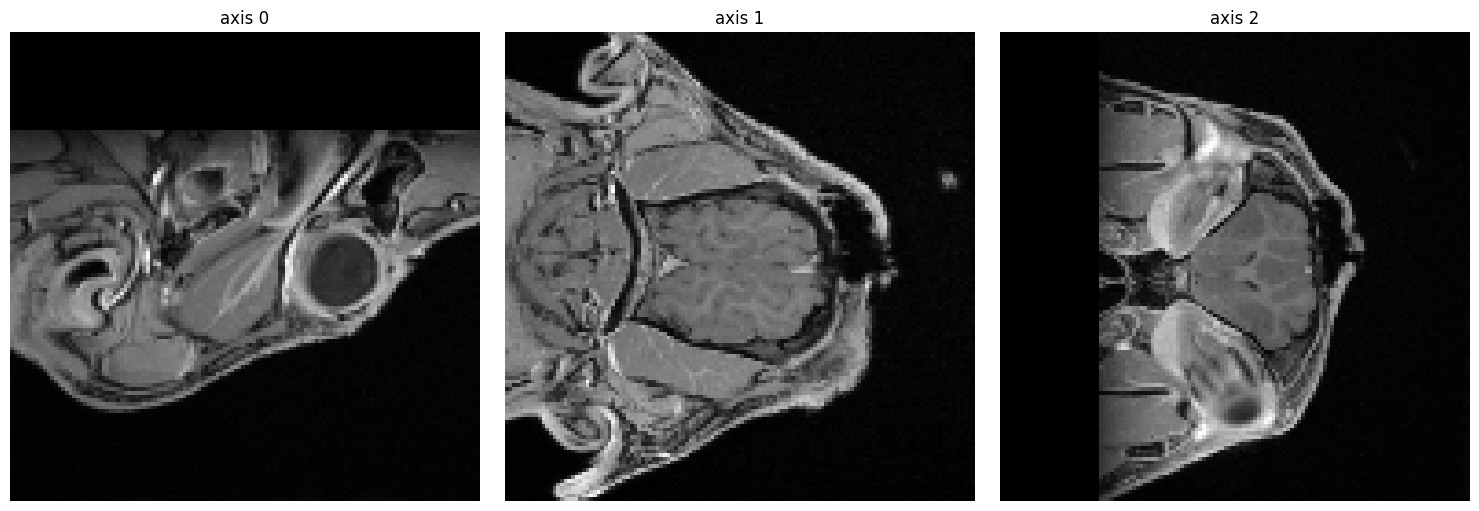

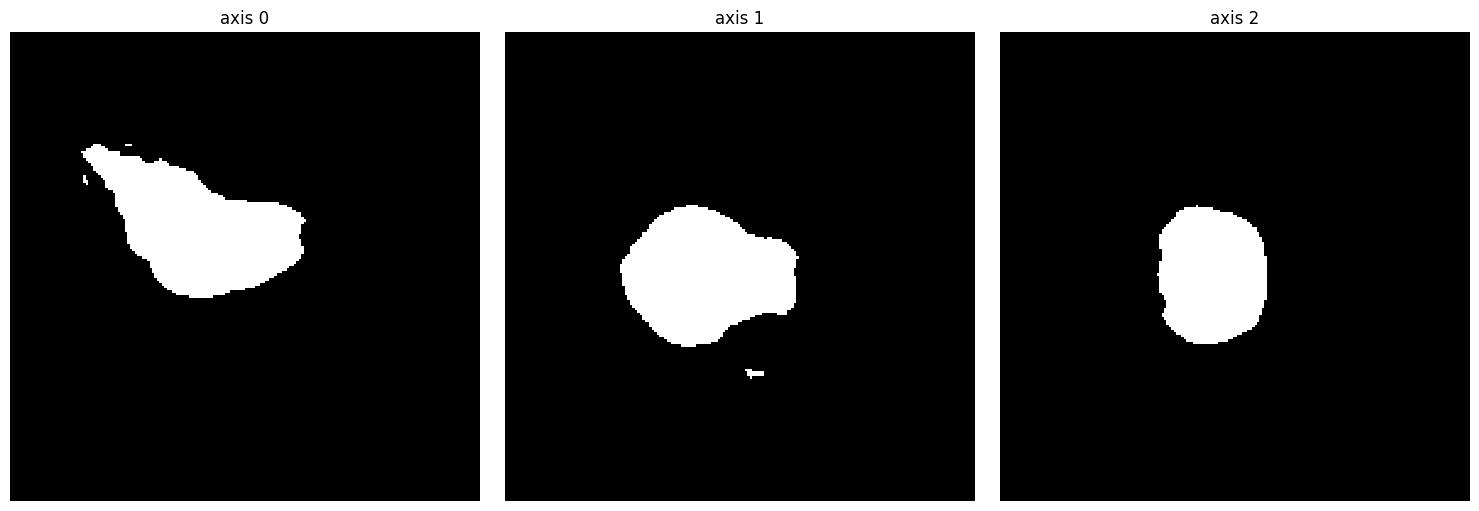

second step:  0.8942533399020488
After Second Prediction:
Dice coefficient for JAW-082: 0.8943
NO MASK FOUND
/cubic/projects/Pig_TBI/JohnWolf/Protocols/T1_mask/JAW-099_pre/JAW-099_pre_T1.nii.gz
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!


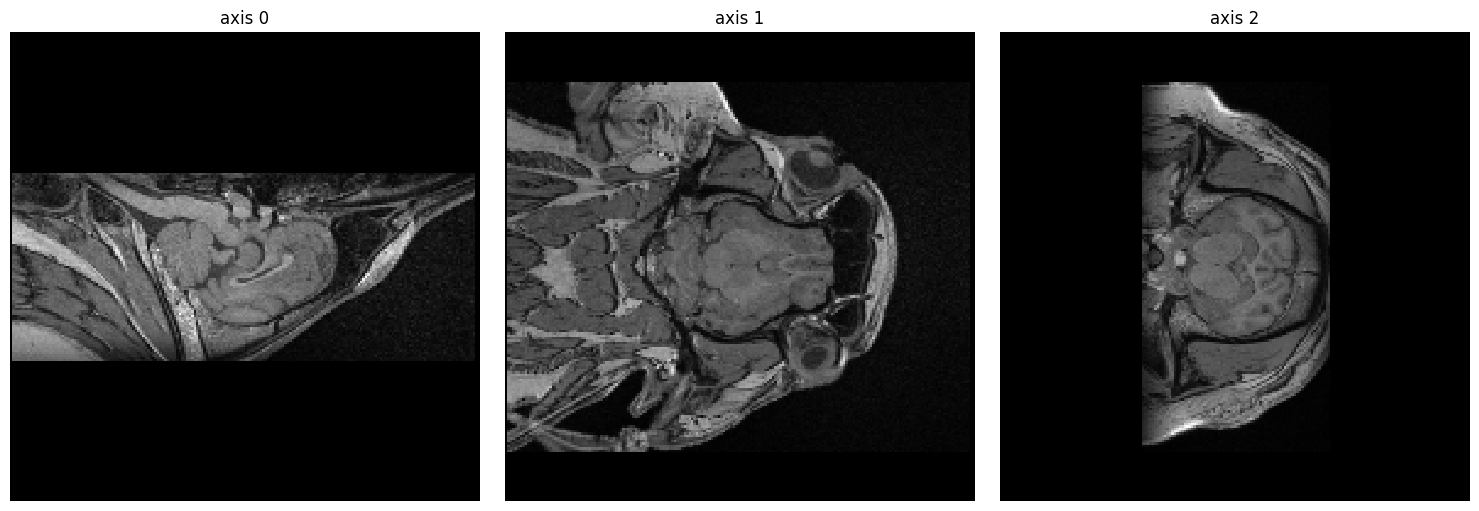

(192, 192, 192)
Initial Prediction Result:
first step:  0.6634381390468881


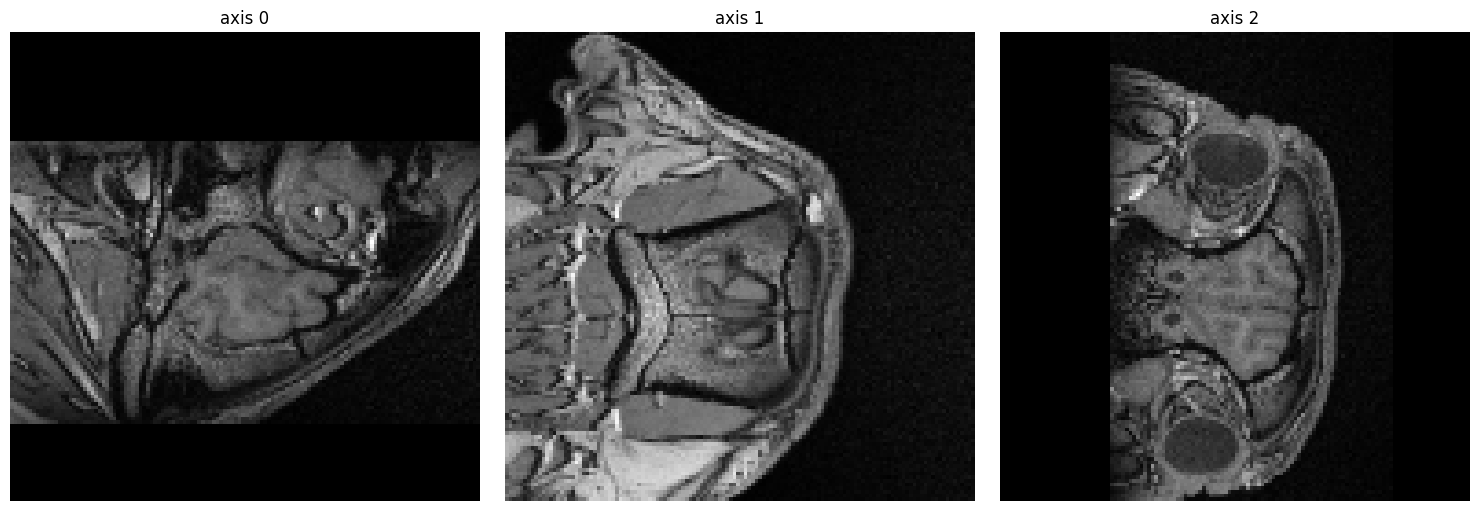

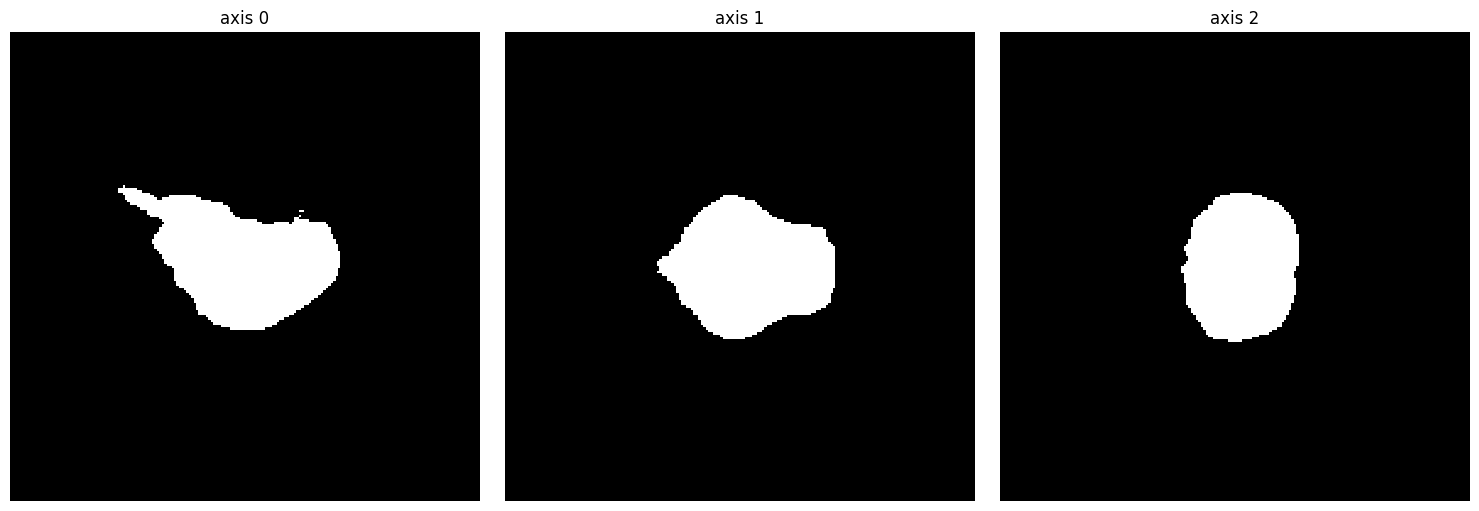

second step:  0.8579514766565126
After Second Prediction:
Dice coefficient for JAW-099_pre: 0.8580
/cubic/projects/Pig_TBI/JohnWolf/Protocols/T1_mask/JAW-093_pre/JAW-093_pre_T1.nii.gz
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!


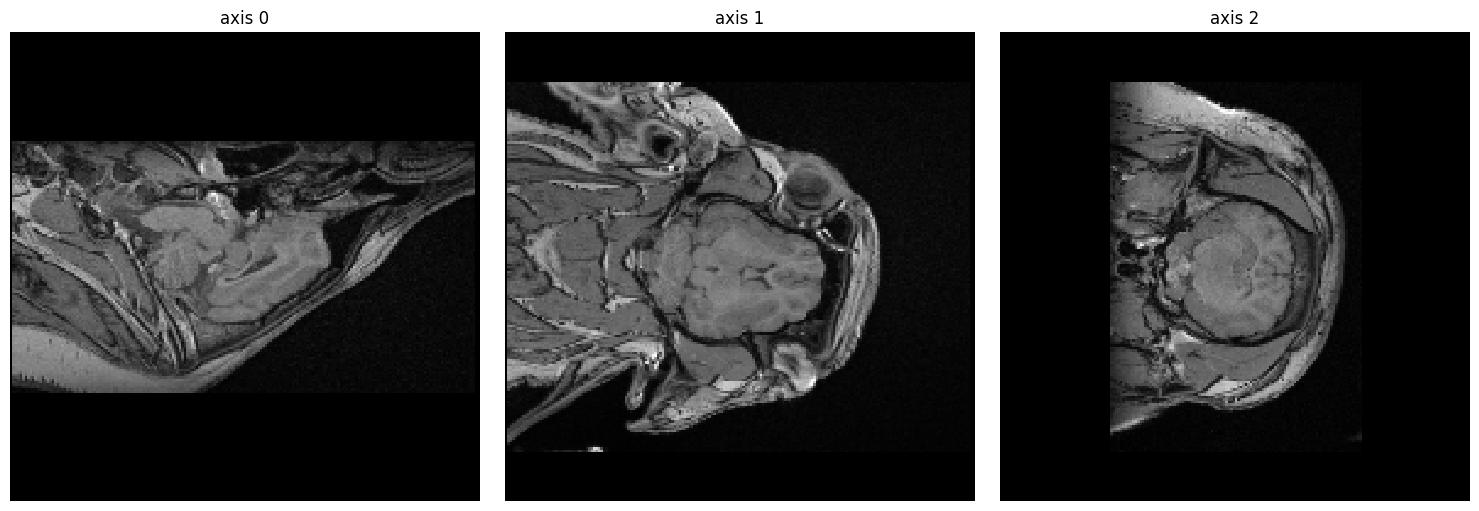

(192, 192, 192)
Initial Prediction Result:
first step:  0.7523039490116705


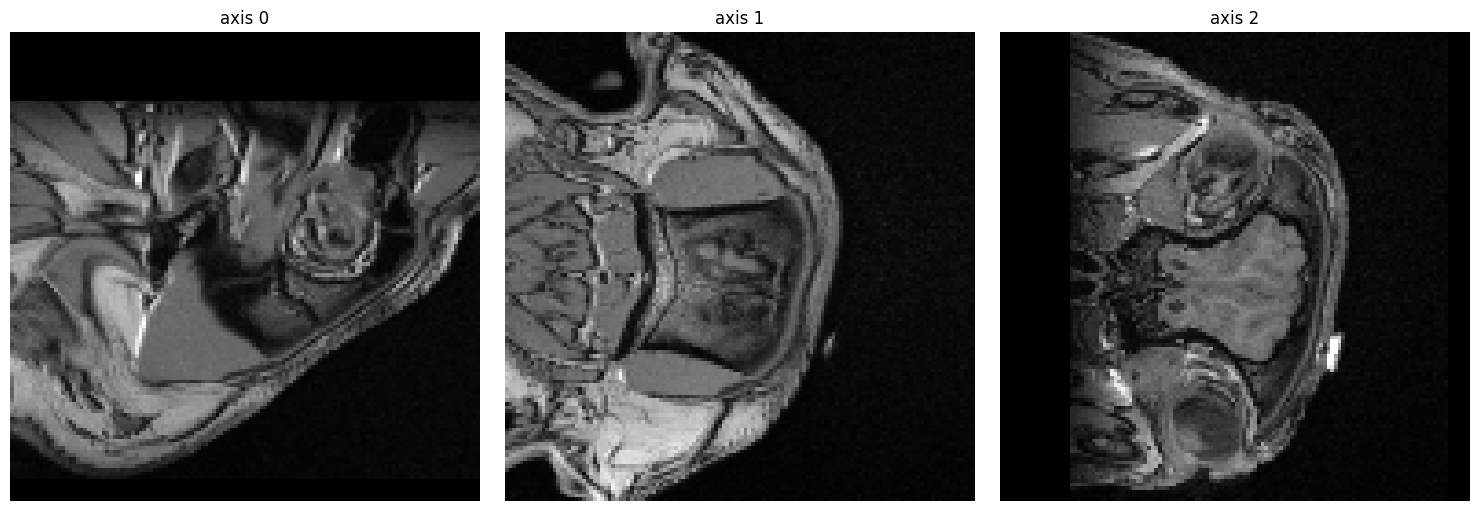

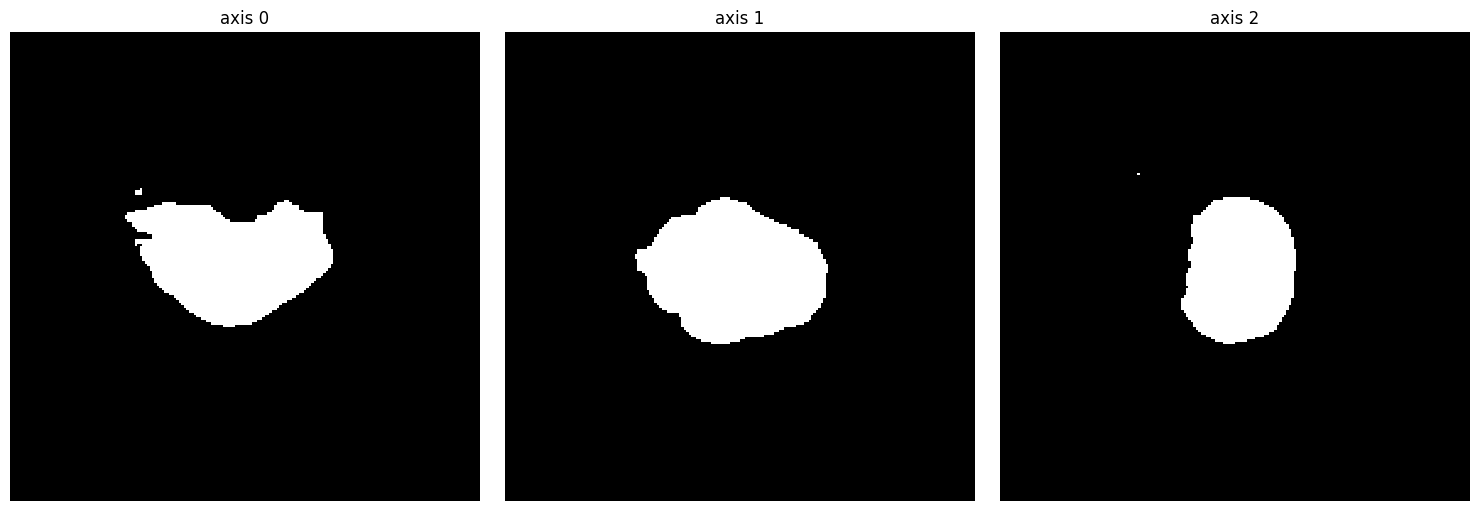

second step:  0.925450664025823
After Second Prediction:
Dice coefficient for JAW-093_pre: 0.9255
/cubic/projects/Pig_TBI/JohnWolf/Protocols/T1_mask/JAW-106_pre/JAW-106_pre_T1.nii.gz
[DEBUG] NiftiArrayIO.load(): no header extensions found!
/cubic/projects/Pig_TBI/JohnWolf/Protocols/T1_mask/JAW-081_3day/JAW-081_3day_T1.nii.gz
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!


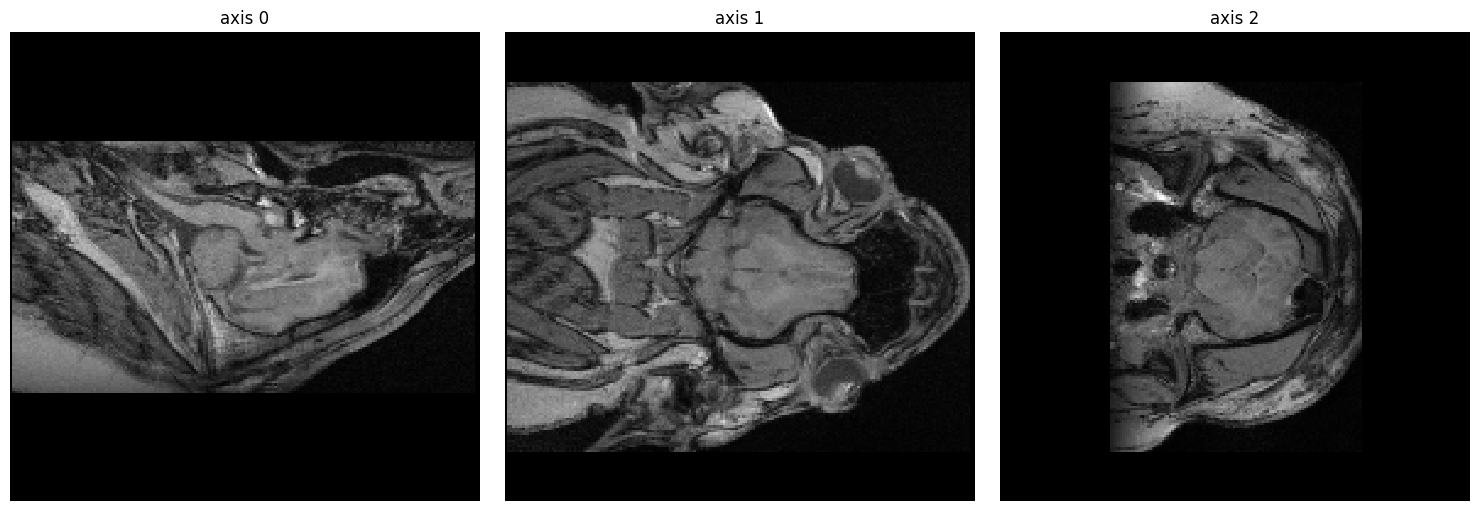

(192, 192, 192)
Initial Prediction Result:
first step:  0.7559903175797575


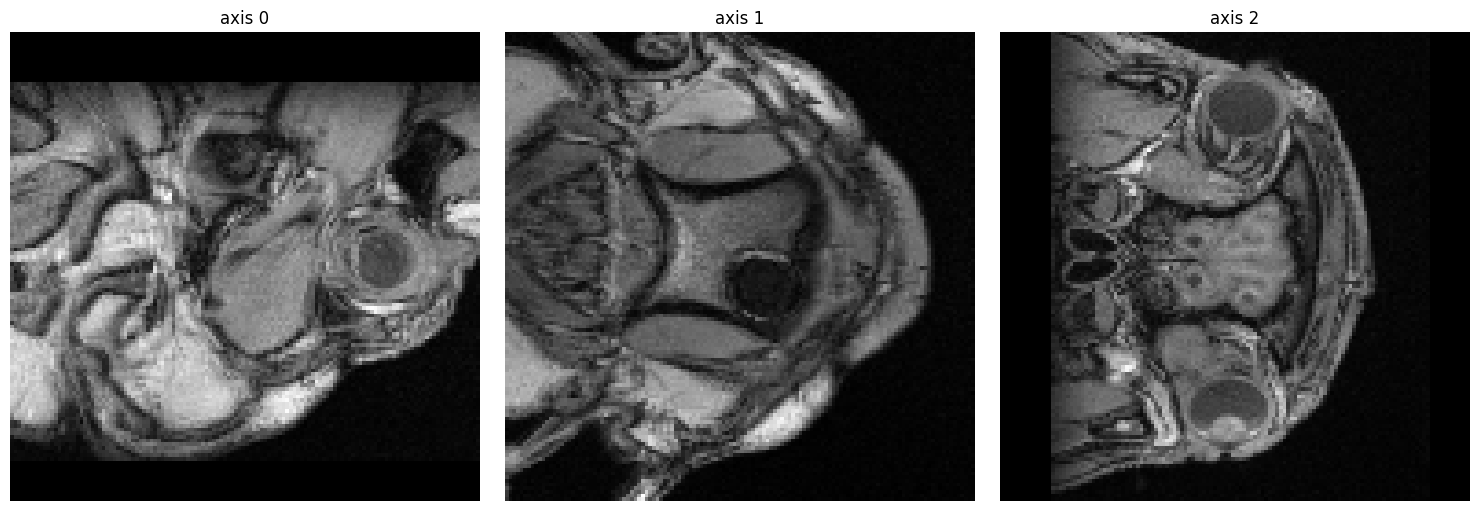

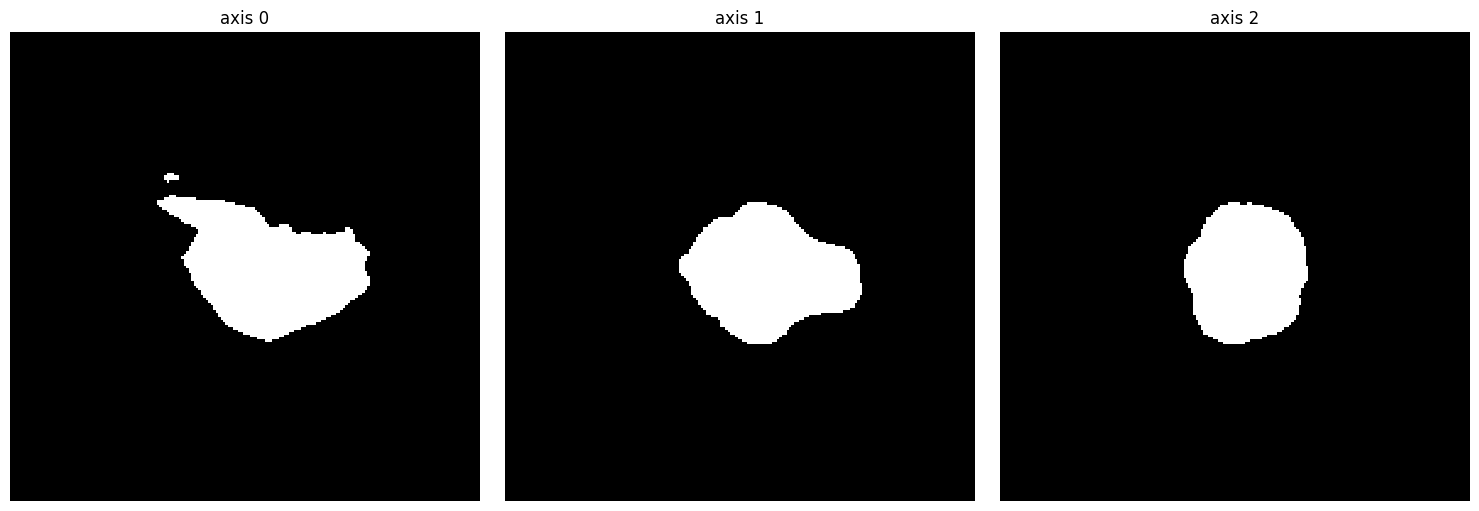

second step:  0.8822698964411126
After Second Prediction:
Dice coefficient for JAW-081_3day: 0.8823
/cubic/projects/Pig_TBI/JohnWolf/Protocols/T1_mask/JAW-106_3day/JAW-106_3day_T1.nii.gz
[DEBUG] NiftiArrayIO.load(): no header extensions found!
/cubic/projects/Pig_TBI/JohnWolf/Protocols/T1_mask/JAW-097_pre/JAW-097_pre_T1.nii.gz
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!


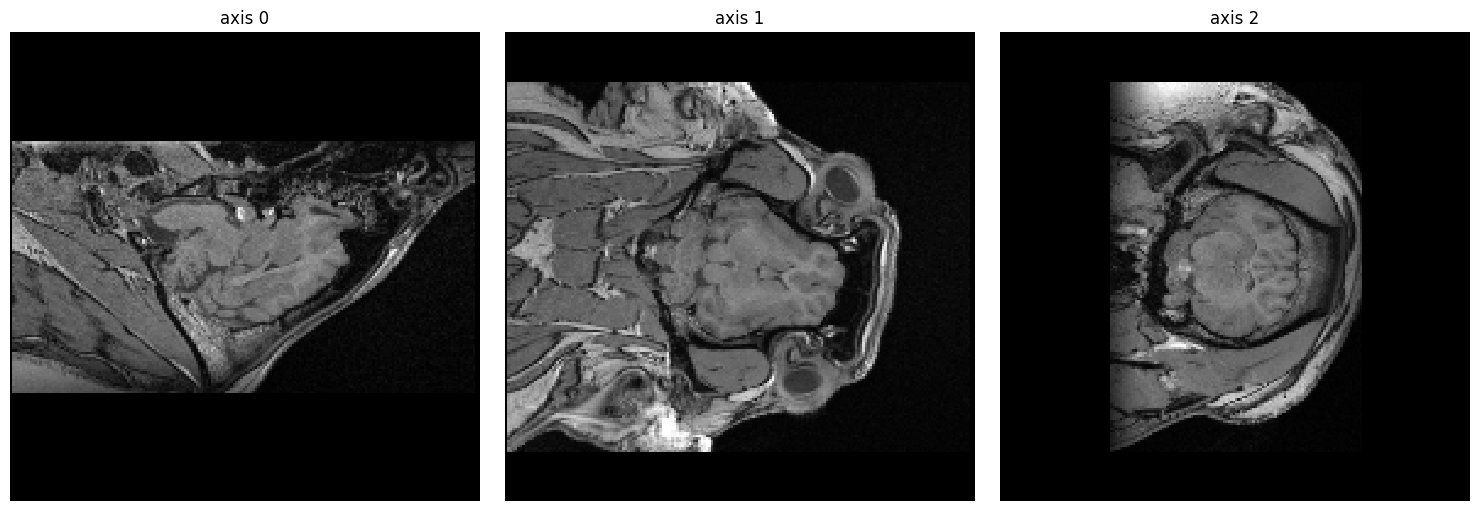

(192, 192, 192)
Initial Prediction Result:
first step:  0.7237085944702607


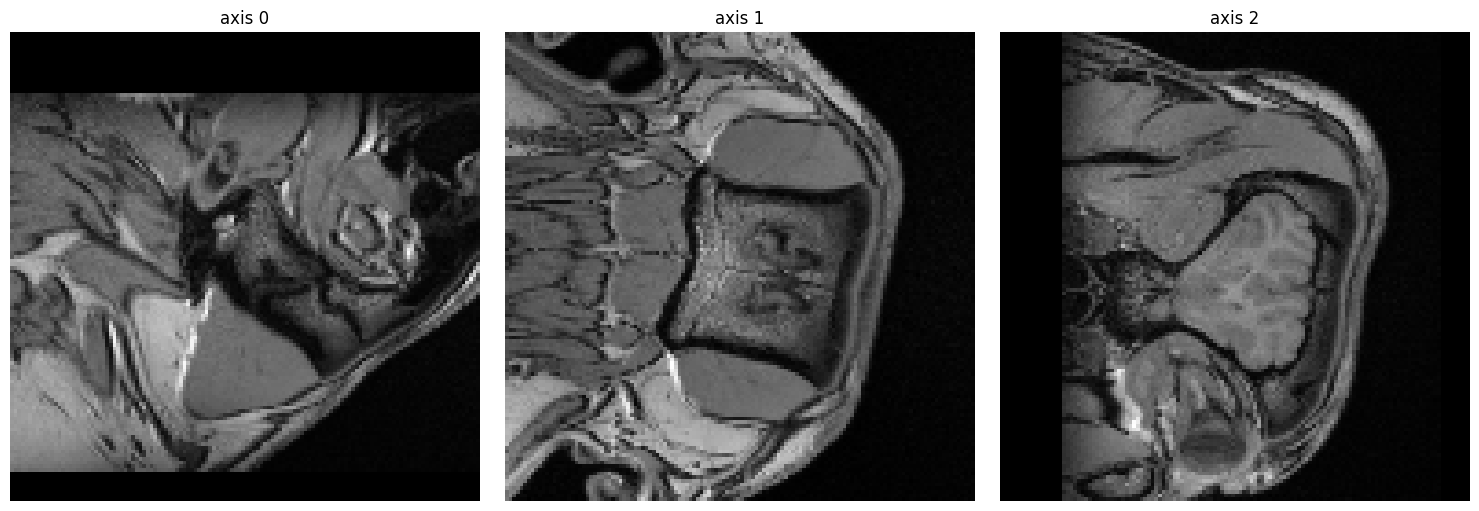

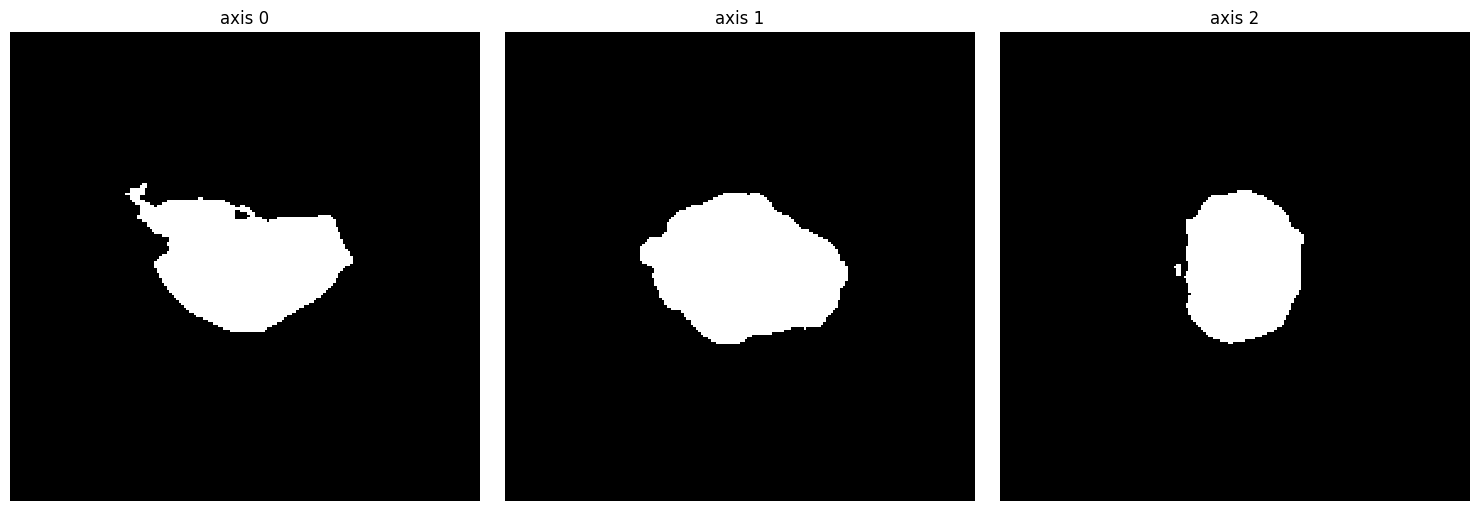

second step:  0.8904756289468013
After Second Prediction:
Dice coefficient for JAW-097_pre: 0.8905
/cubic/projects/Pig_TBI/JohnWolf/Protocols/T1_mask/JAW-101_pre/JAW-101_pre_T1.nii.gz
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!


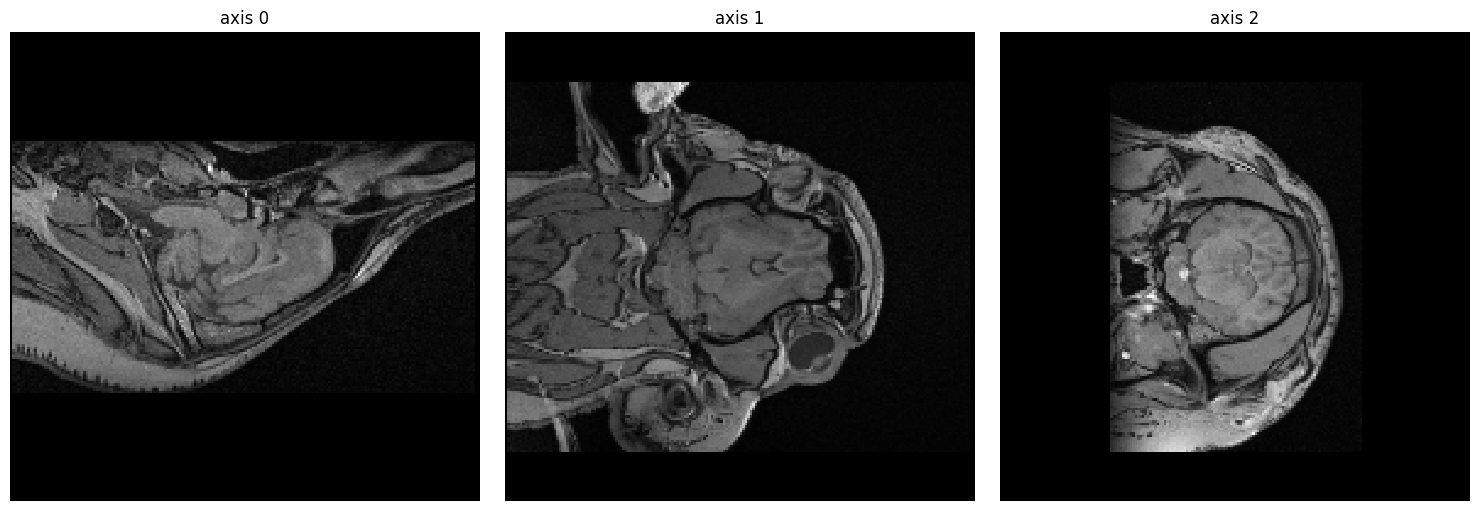

(192, 192, 192)
Initial Prediction Result:
first step:  0.6220284288218676


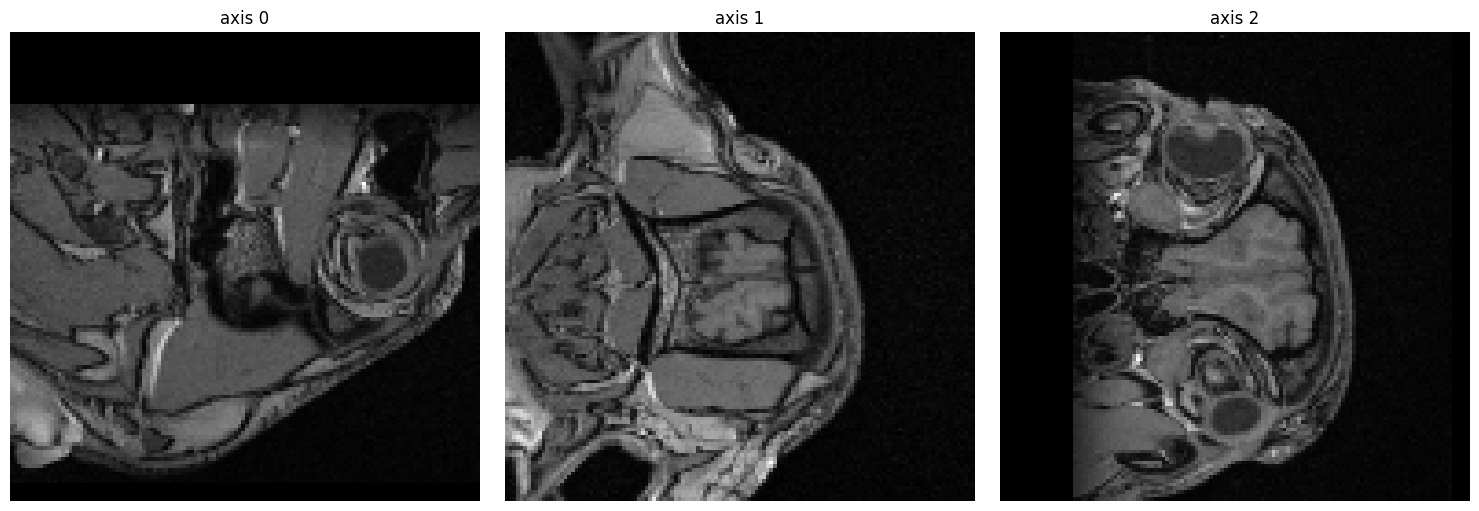

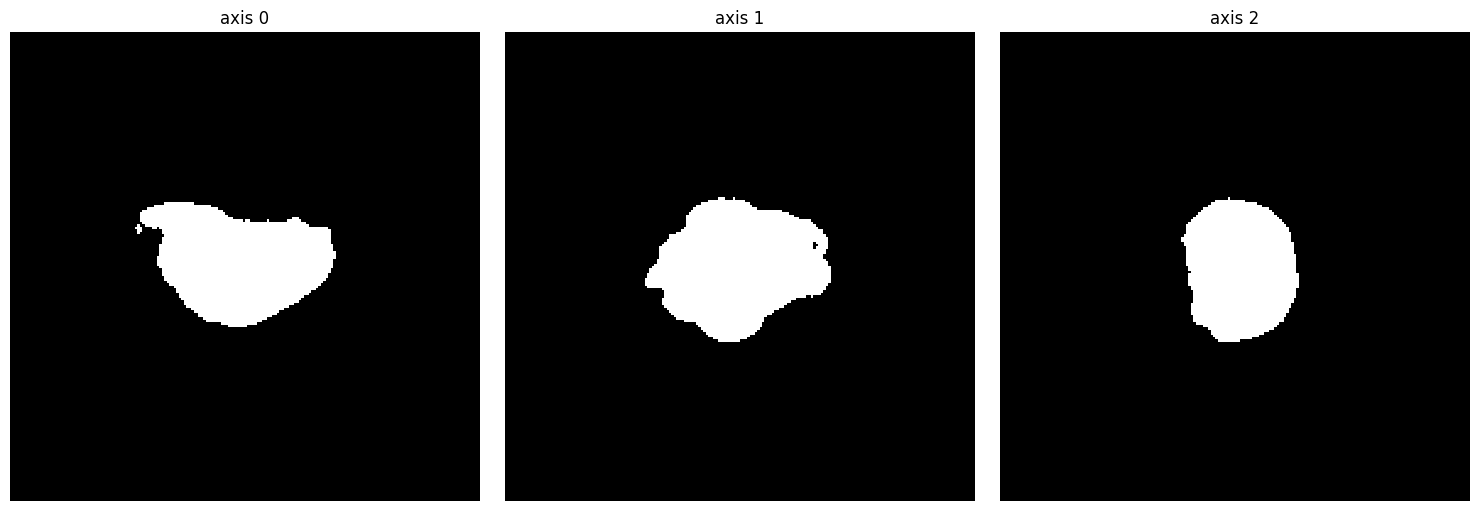

second step:  0.8976224942954585
After Second Prediction:
Dice coefficient for JAW-101_pre: 0.8976
/cubic/projects/Pig_TBI/JohnWolf/Protocols/T1_mask/JAW-076_pre/JAW-076_pre_T1.nii.gz
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!


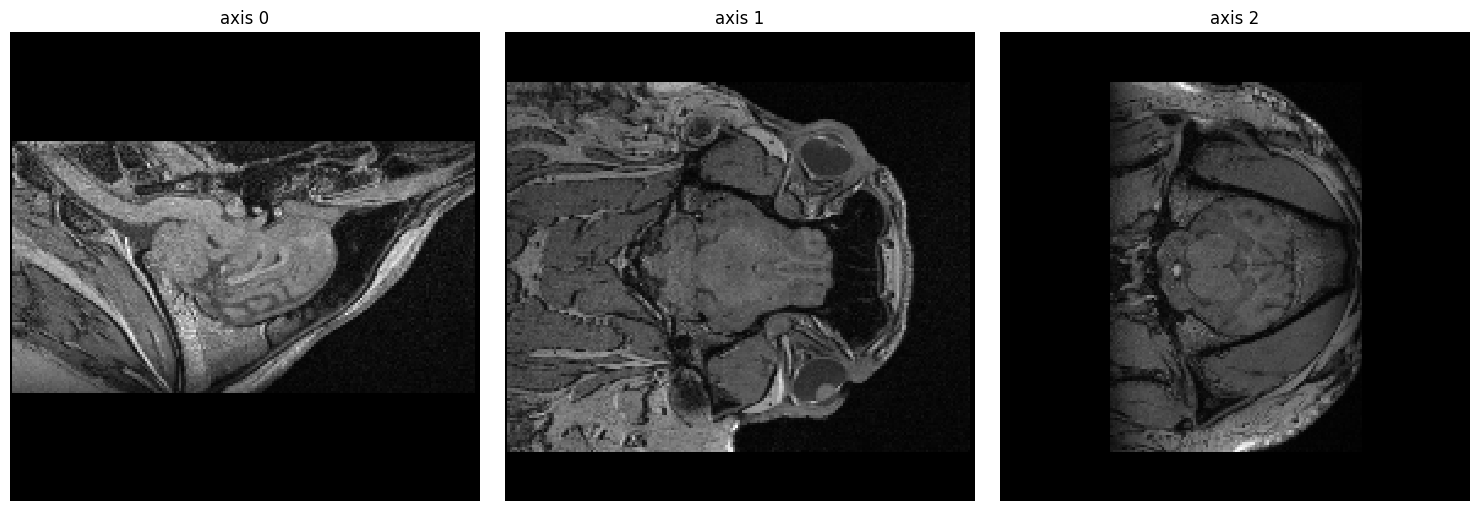

(192, 192, 192)
Initial Prediction Result:
first step:  0.6936476559600162


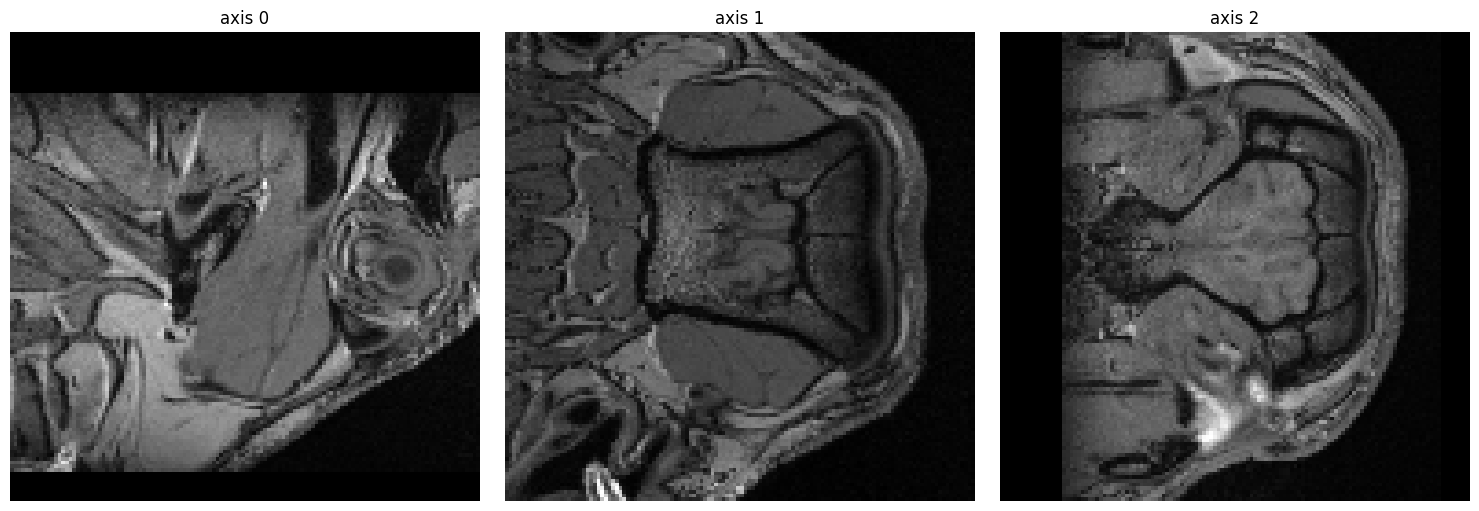

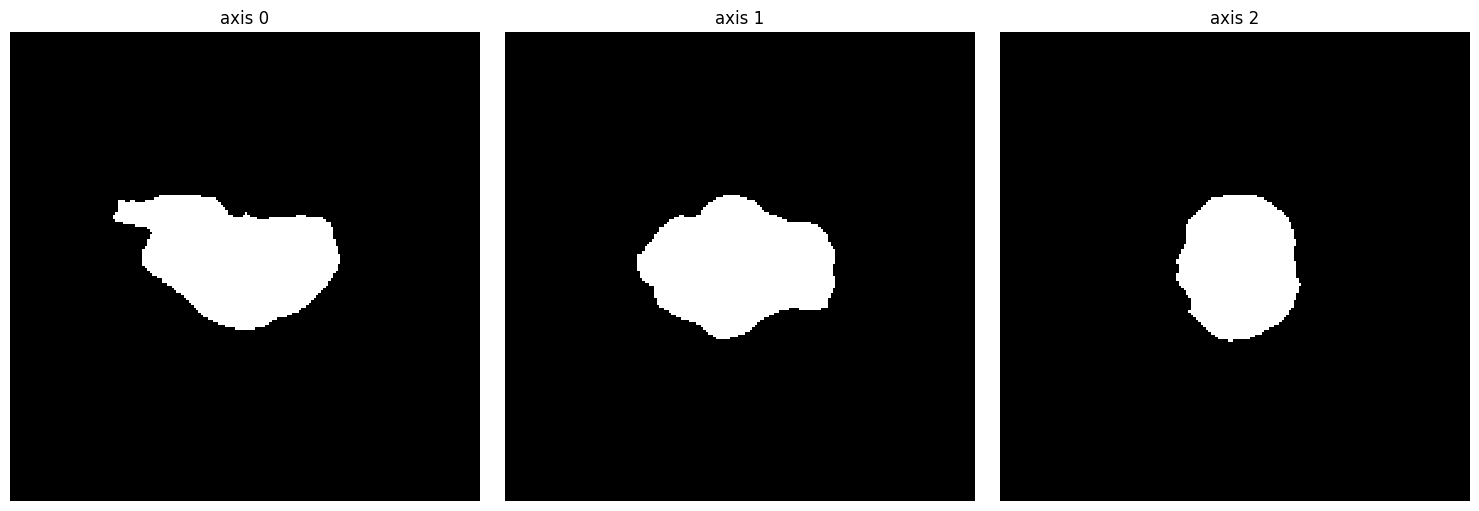

second step:  0.8699137636440388
After Second Prediction:
Dice coefficient for JAW-076_pre: 0.8699
/cubic/projects/Pig_TBI/JohnWolf/Protocols/T1_mask/JAW-081_pre/JAW-081_pre_T1.nii.gz
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!


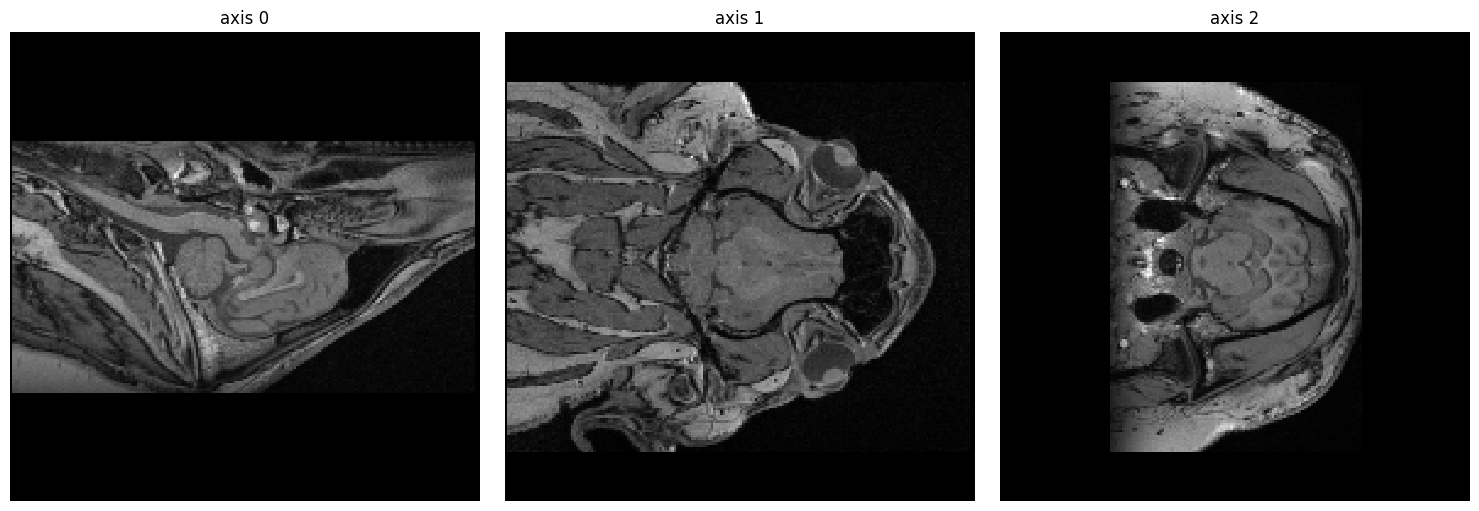

(192, 192, 192)
Initial Prediction Result:
first step:  0.6808632342684536


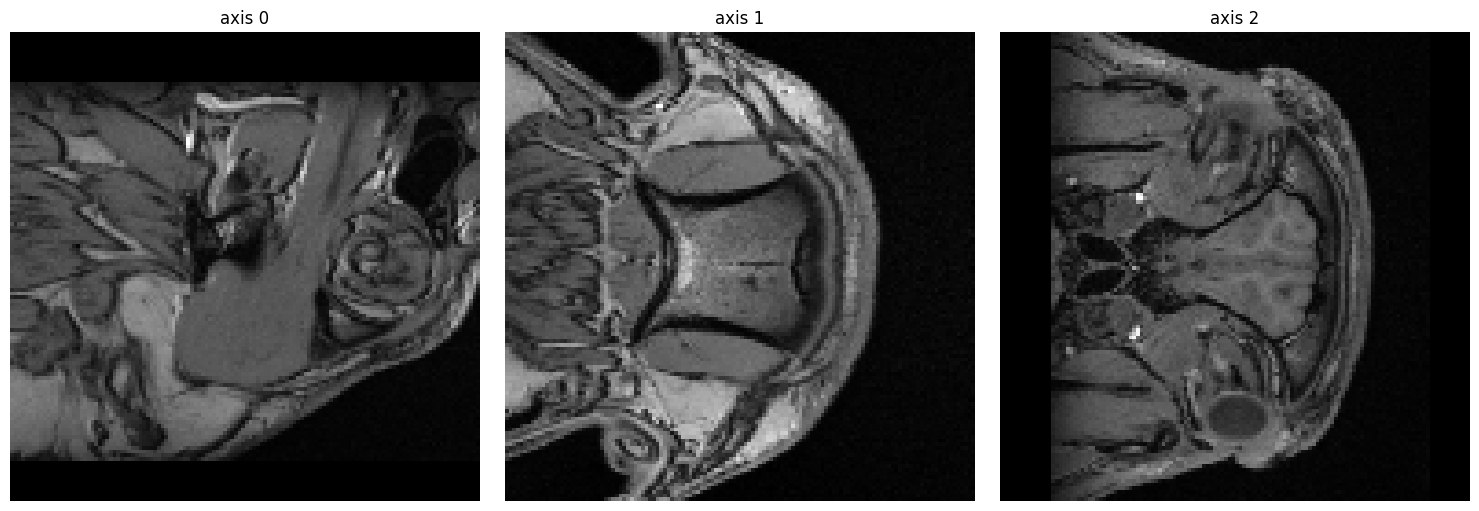

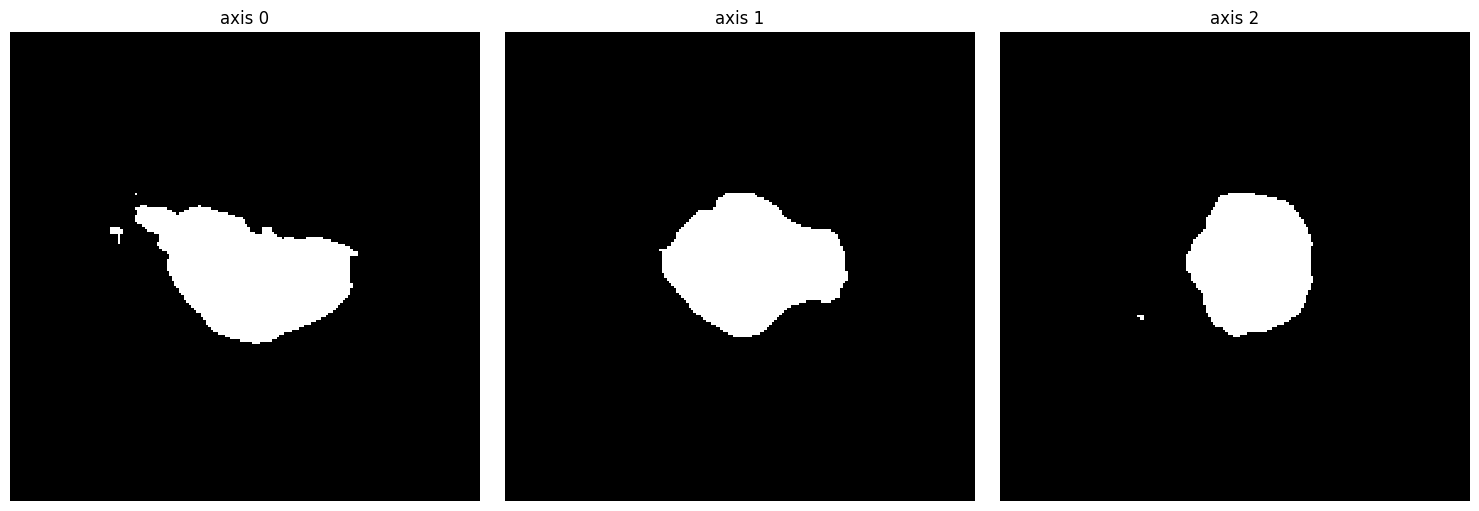

second step:  0.8712077505267162
After Second Prediction:
Dice coefficient for JAW-081_pre: 0.8712
/cubic/projects/Pig_TBI/JohnWolf/Protocols/T1_mask/JAW-096_pre/JAW-096_pre_T1.nii.gz
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!


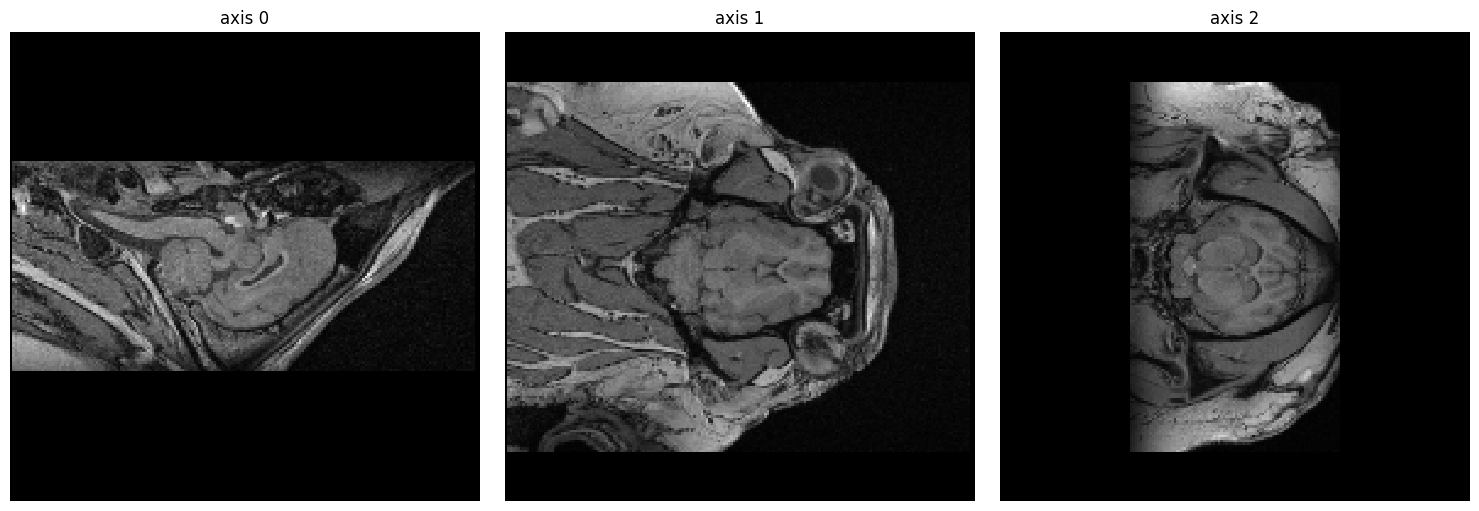

(192, 192, 192)
Initial Prediction Result:
first step:  0.6307286532569601


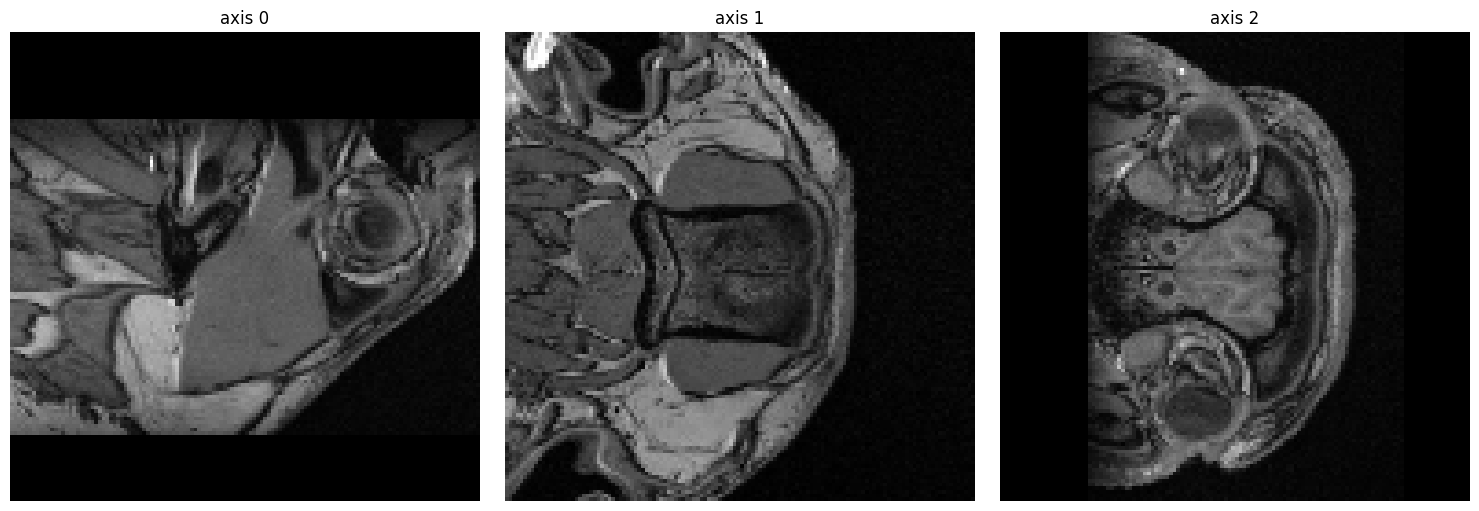

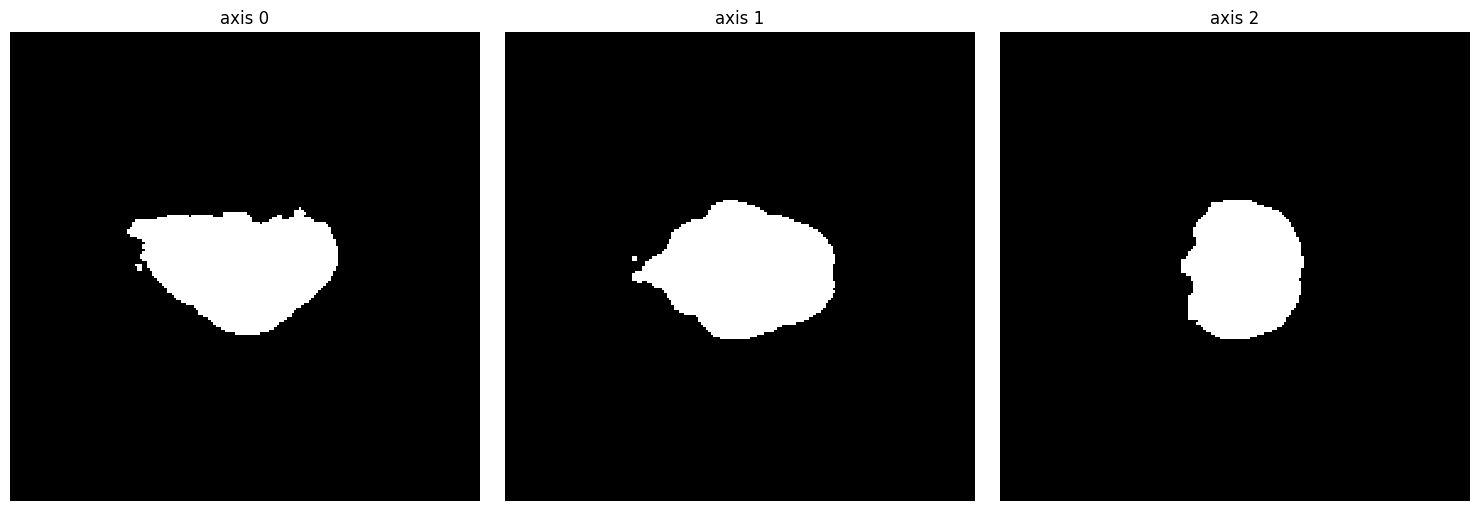

second step:  0.883229633916944
After Second Prediction:
Dice coefficient for JAW-096_pre: 0.8832
/cubic/projects/Pig_TBI/JohnWolf/Protocols/T1_mask/JAW-106_3month/JAW-106_3month_T1.nii.gz
[DEBUG] NiftiArrayIO.load(): no header extensions found!
/cubic/projects/Pig_TBI/JohnWolf/Protocols/T1_mask/JAW-076_6month/JAW-076_6month_T1.nii.gz
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!


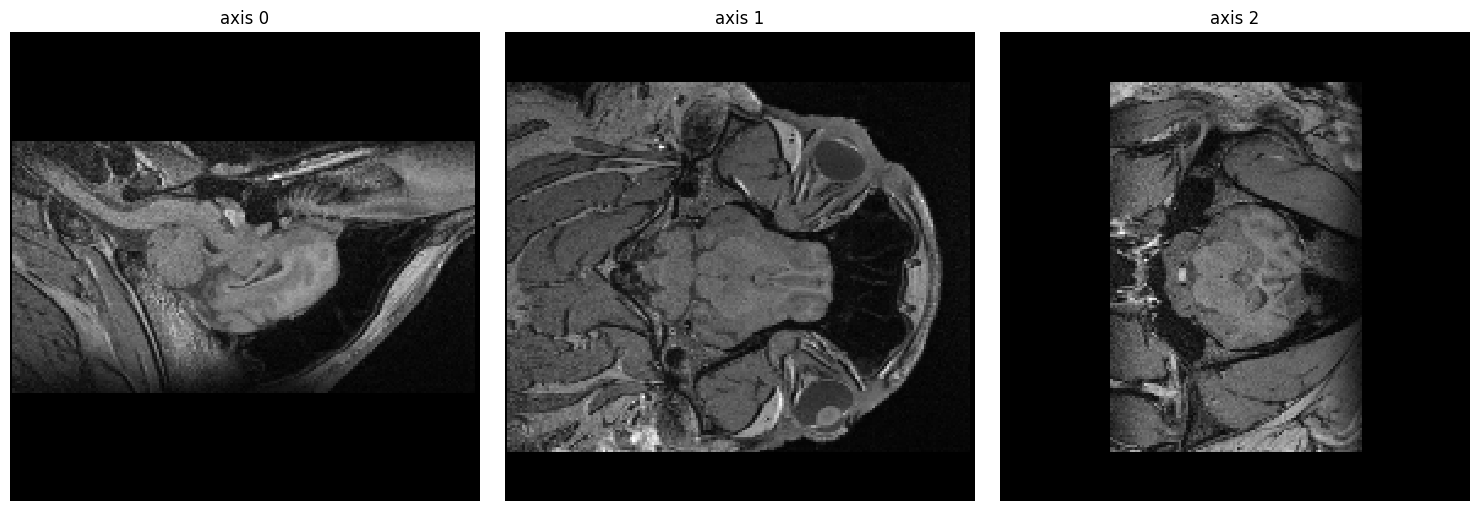

(192, 192, 192)
Initial Prediction Result:
first step:  0.6210350335109638


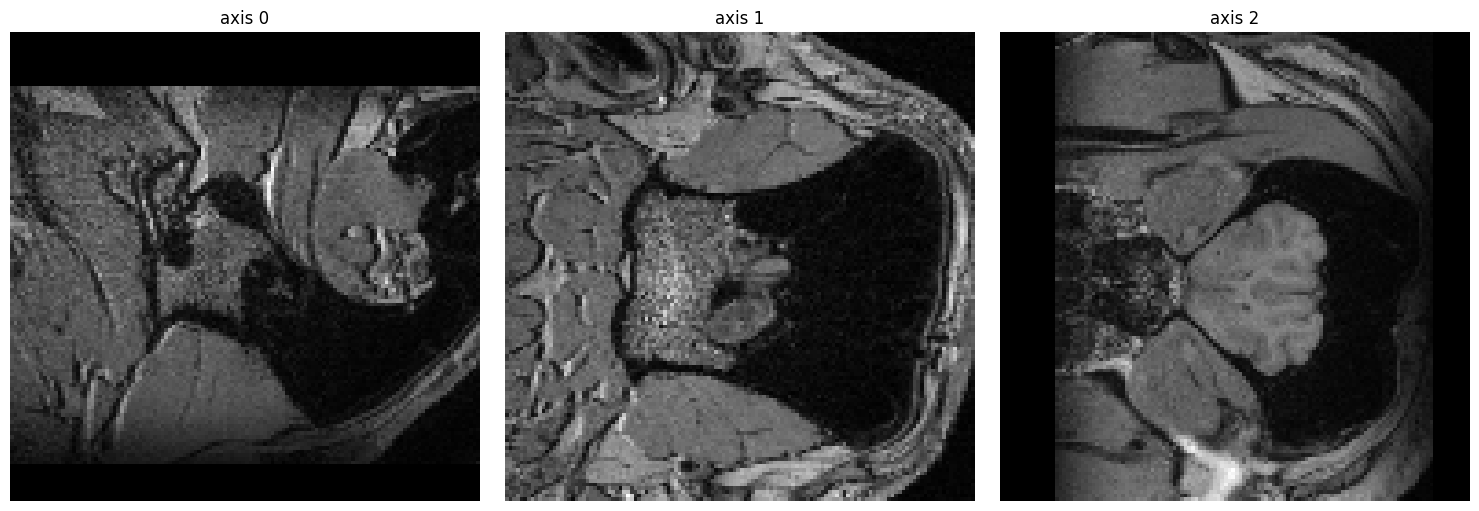

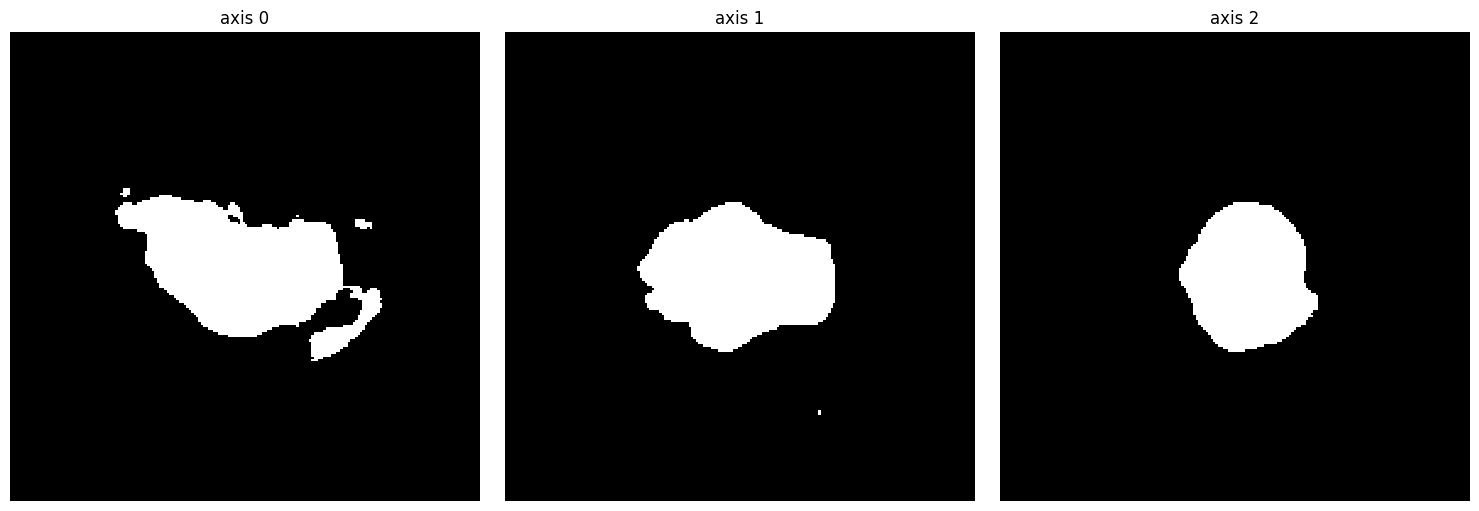

second step:  0.806283251057472
After Second Prediction:
Dice coefficient for JAW-076_6month: 0.8063
/cubic/projects/Pig_TBI/JohnWolf/Protocols/T1_mask/JAW-081_6month/JAW-081_6month_T1.nii.gz
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!


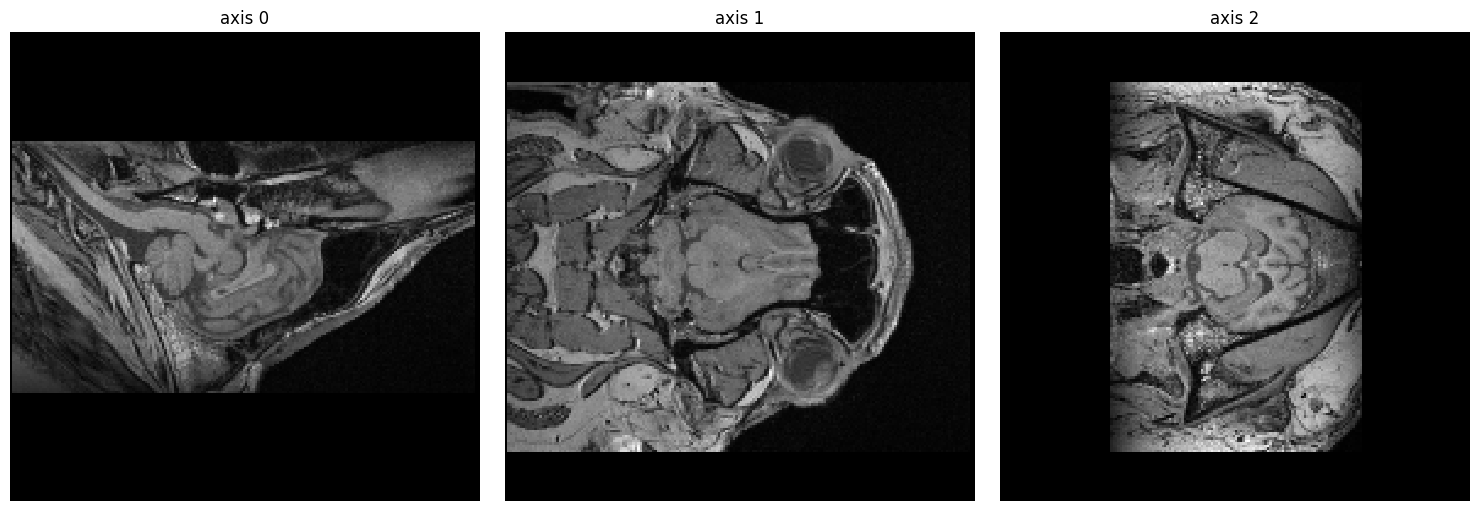

(192, 192, 192)
Initial Prediction Result:
first step:  0.6959157611536032


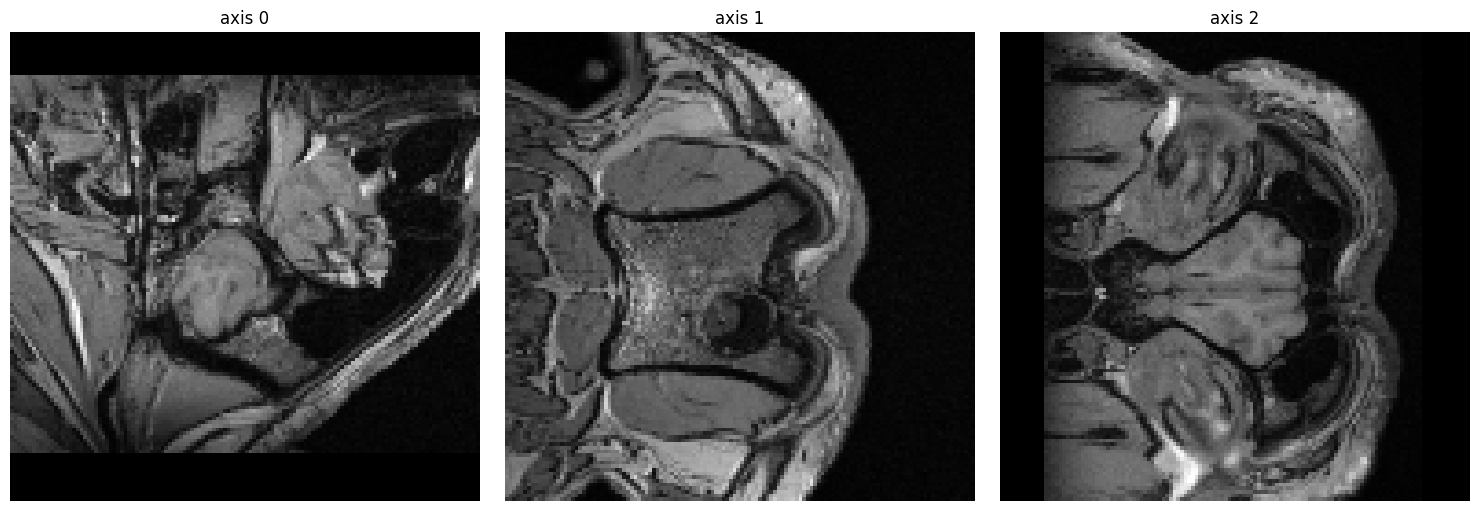

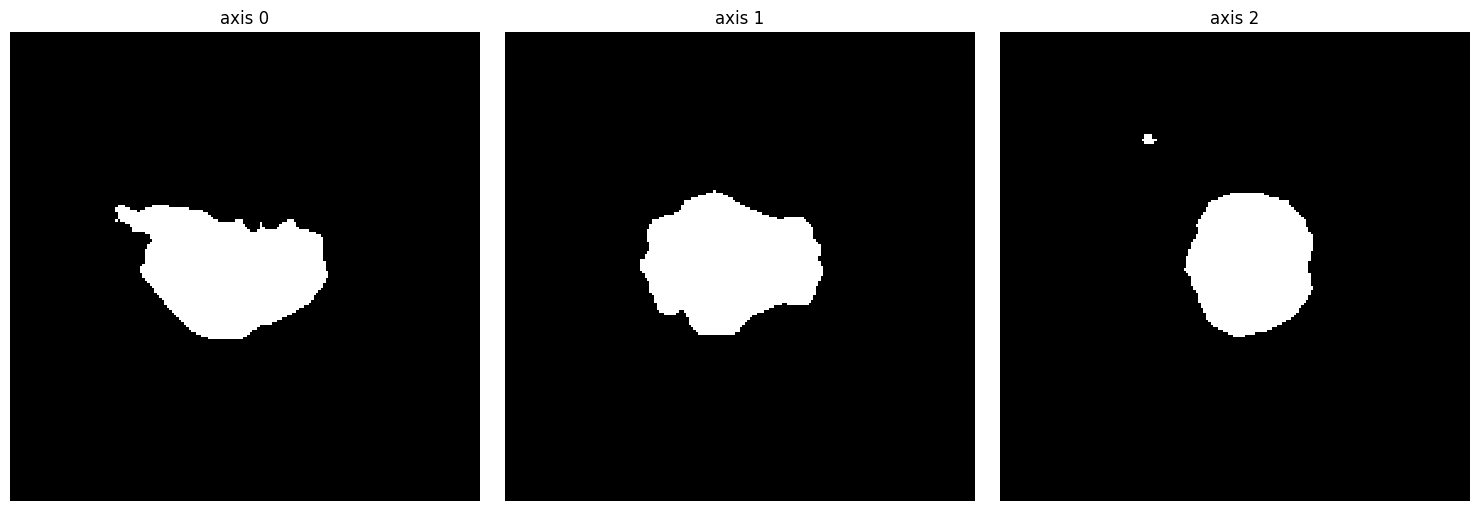

second step:  0.8613147453426594
After Second Prediction:
Dice coefficient for JAW-081_6month: 0.8613
/cubic/projects/Pig_TBI/JohnWolf/Protocols/T1_mask/JAW-081_3month/JAW-081_3month_T1.nii.gz
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!


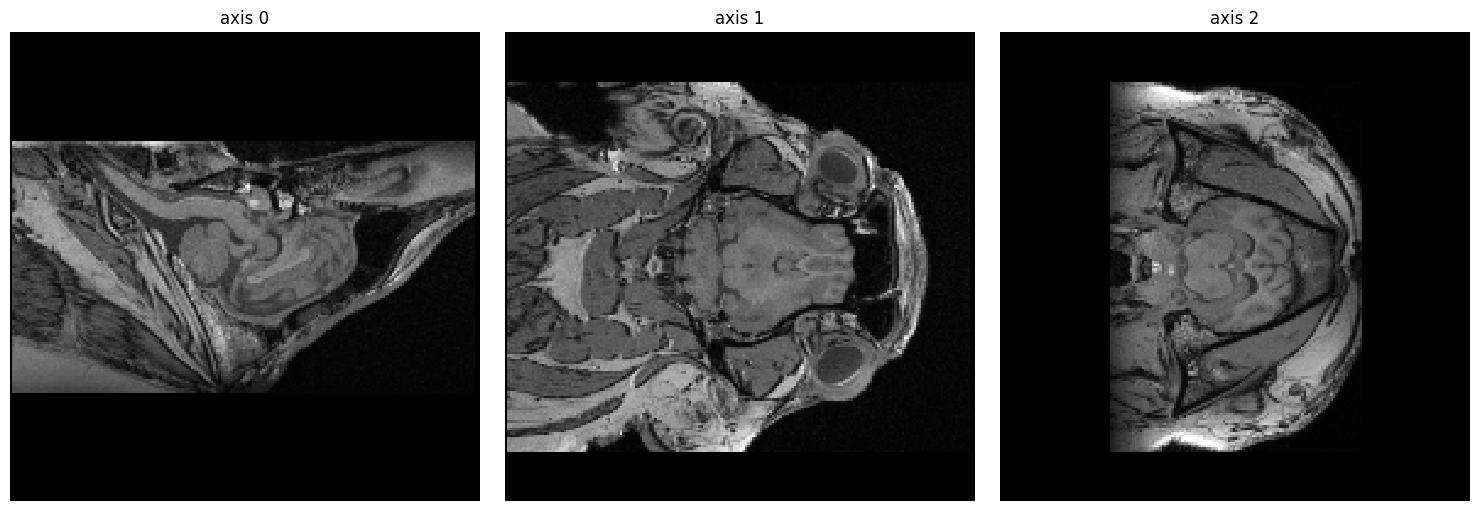

(192, 192, 192)
Initial Prediction Result:
first step:  0.6597068935996927


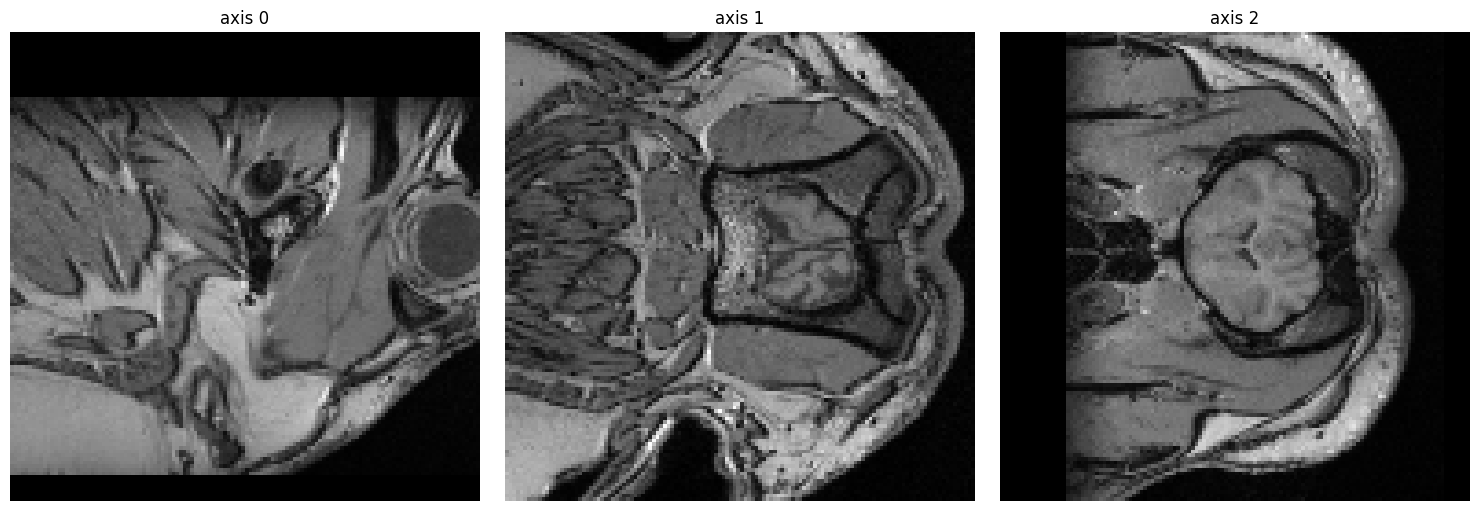

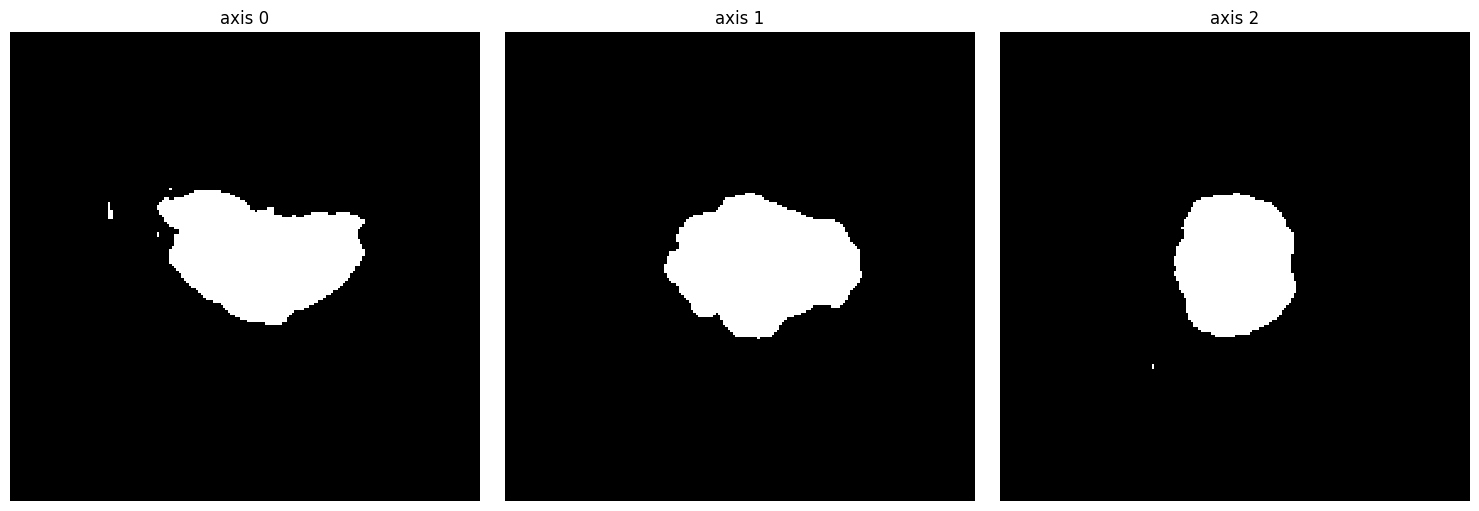

second step:  0.8664181397680775
After Second Prediction:
Dice coefficient for JAW-081_3month: 0.8664
/cubic/projects/Pig_TBI/JohnWolf/Protocols/T1_mask/JAW-076_1month/JAW-076_1month_T1.nii.gz
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!


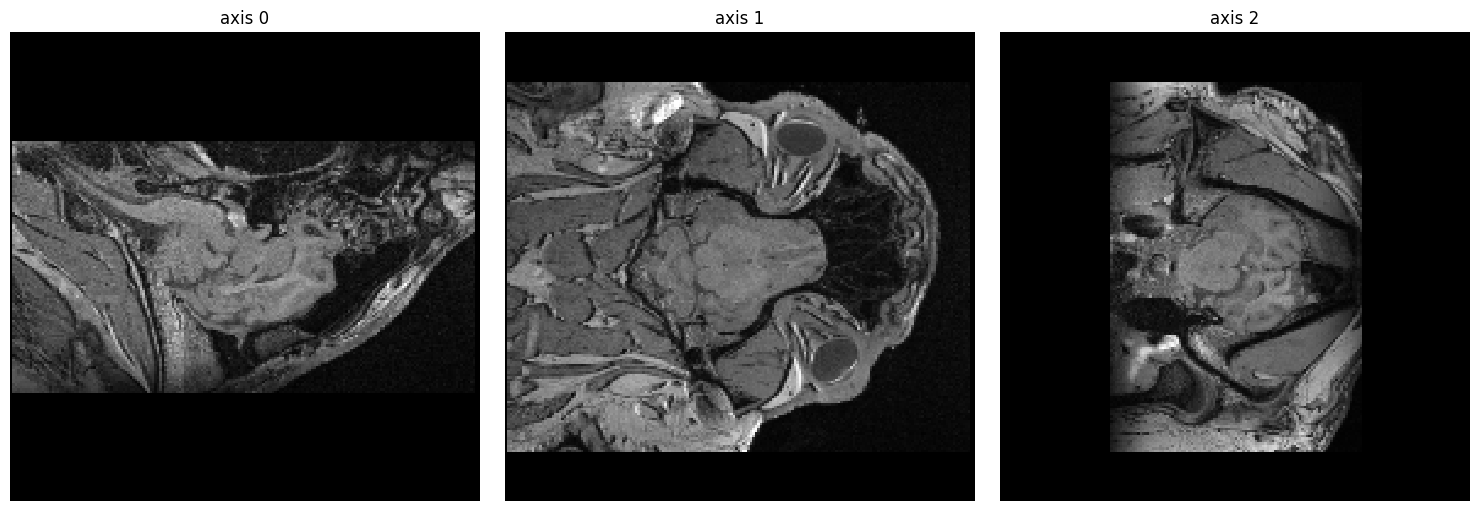

(192, 192, 192)


In [ ]:
import os
import numpy as np
import surfa as sf
import neurite as ne
from scipy import ndimage
from sklearn.metrics import jaccard_score
from utils import find_bounding_box, find_random_bounding_box, apply_gaussian_smoothing, extract_cube

# Store Dice coefficients
dice_scores = []

new_voxsize = [1, 1, 1]

import numpy as np

def refine_prediction(crop_img, mask, model, model_128, new_image_size=(192, 192, 192), margin=0, cube_size=128):
    """
    Refines the segmentation prediction in two steps:
    1. Makes an initial prediction.
    2. Crops the image based on the prediction and runs the model again.
    
    Parameters:
    - crop_img (ndarray): The input image for prediction.
    - mask (ndarray): The binary mask.
    - model: The trained segmentation model.
    - new_image_size (tuple): The new voxel size for resizing (default is (192, 192, 192)).
    - margin (int): The margin to add around the bounding box (default is 10).
    - cube_size (int): The size of the bounding cube (default is 32).
    
    Returns:
    - final_prediction_resized (ndarray): The final refined prediction, resized to match the original input size.
    """
    
    # Step 1: Initial Prediction
    # Binarize the mask
    mask.data[mask.data != 0] = 1

    # Compute mask center (using the provided find_bounding_box function)
    ms = np.mean(np.column_stack(np.nonzero(mask)), axis=0).astype(int)
    print(crop_img.shape)
    
    # Make an initial prediction
    prediction_one_hot = model.predict(crop_img[None, ...], verbose=0)
    initial_prediction = np.argmax(prediction_one_hot, axis=-1)[0]
    # ne.plot.volume3D(crop_img, slice_nos=ms)
    print("Initial Prediction Result:")

    labeled, num_components = ndimage.label(initial_prediction > 0)
    largest_mask = labeled == np.argmax(ndimage.sum(initial_prediction > 0, labeled, range(num_components + 1)))
    initial_prediction = ndi.binary_fill_holes(largest_mask)

    # ne.plot.volume3D(initial_prediction, slice_nos=ms)
    print("first step: ",my_hard_dice(mask.data, initial_prediction))

    # Step 2: Use find_bounding_box function to get the bounding box
    x1, y1, z1, x2, y2, z2 = find_bounding_box(initial_prediction, cube_size=cube_size)
    cube = extract_cube(crop_img, x1, y1, z1, x2, y2, z2, cube_size=128)


    pred_192 = np.zeros((192,192,192))

    ms = np.mean(np.column_stack(np.nonzero(mask)), axis=0).astype(int)
    ne.plot.volume3D(cube, slice_nos=ms)

    # Step 3: Re-run the Model with the cropped image
    prediction_cropped_one_hot = model_128.predict(cube[None, ...], verbose=0)
    final_prediction = np.argmax(prediction_cropped_one_hot, axis=-1)[0]
    pred_192[x1:x2, y1:y2, z1:z2] = final_prediction
    
    labeled, num_components = ndimage.label(pred_192 > 0)
    largest_mask = labeled == np.argmax(ndimage.sum(pred_192 > 0, labeled, range(num_components + 1)))
    largest_mask = ndi.binary_fill_holes(largest_mask)
    
    ne.plot.volume3D(pred_192, slice_nos=ms)
    print("second step: ",my_hard_dice(mask.data, pred_192))
    # Step 4: Resize the final prediction to the original crop_img size
    # final_prediction_resized = np.resize(final_prediction, (192, 192, 192))

    return pred_192


for folder in subfolders:
    folder_path = os.path.join(validation_folder_path, folder)
    folder_name = os.path.basename(folder_path)
        
    filename = os.path.join(folder_path, f"{folder_name}_T1.nii.gz")
    mask_filename = os.path.join(folder_path, f"{folder_name}_T1_mask.nii.gz")

    if "JAW-106_6month" in filename:
        print("NO MASK FOUND")
        continue
        
    print(filename)
    
    # Load mask
    if not os.path.isfile(mask_filename):
        mask = sf.Volume(np.ones((192, 192, 192)))
    else:
        mask = sf.load_volume(mask_filename).resize(new_voxsize, method="linear")
        mask = mask.resize(new_voxsize).reshape([192, 192, 192, 1])

    # Skip if no input file
    if not os.path.isfile(filename):
        continue
        
    # Load and process image
    image = sf.load_volume(filename)
    crop_img = image.resize(new_voxsize, method="linear").reshape([192, 192, 192, 1])

    # Binarize the mask
    mask.data[mask.data != 0] = 1
    


    # Compute mask center
    ms = np.mean(np.column_stack(np.nonzero(mask)), axis=0).astype(int)
    
    # Plot input image and mask

    # Create a figure and axes for two subplots (1 row, 2 columns)

    ne.plot.volume3D(crop_img, slice_nos=ms)
    # ne.plot.volume3D(mask, slice_nos=ms)

    # Predict segmentation
    # prediction_one_hot = combined_model.predict(crop_img[None, ...], verbose=0)
    # prediction = np.argmax(prediction_one_hot, axis=-1)[0]

    prediction = refine_prediction(crop_img, mask, combined_model,combined_model_128, new_image_size=(192, 192, 192))

    # Extract the largest connected component

    print("After Second Prediction:")
    # ne.plot.volume3D(largest_mask, slice_nos=ms)

    # Compute Dice coefficient
    mask_flat = mask.data.flatten()
    prediction_flat = prediction.flatten()
    dice_score = 2 * np.sum(mask_flat * prediction_flat) / (np.sum(mask_flat) + np.sum(prediction_flat))
    if np.sum(mask.data)<1000:
        continue
    dice_scores.append(dice_score)

    print(f"Dice coefficient for {folder_name}: {dice_score:.4f}")
    # break

# Overall Dice coefficient and visualization
overall_dice = np.mean(dice_scores)
print(f"Overall Dice coefficient: {overall_dice:.4f}")




In [6]:
overall_dice

0.33212203610709956

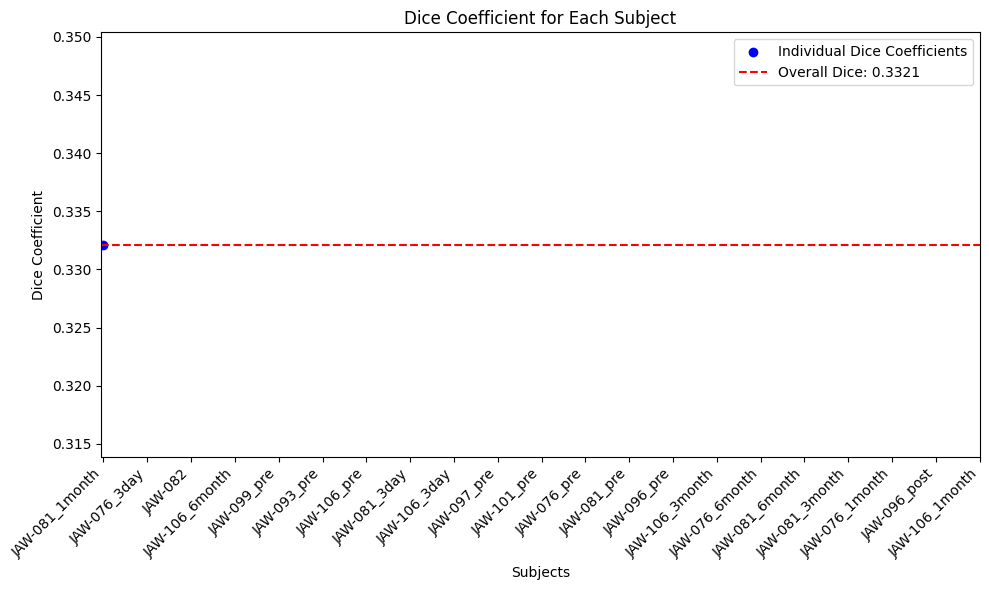

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(range(len(dice_scores)), dice_scores, color='blue', label='Individual Dice Coefficients')
plt.axhline(overall_dice, color='red', linestyle='--', label=f'Overall Dice: {overall_dice:.4f}')
plt.xlabel('Subjects')
plt.ylabel('Dice Coefficient')
plt.title('Dice Coefficient for Each Subject')
plt.legend()
plt.xticks(range(len(subfolders)), subfolders, rotation=45, ha='right')
plt.tight_layout()
plt.show()
